<a href="https://colab.research.google.com/github/Jezen5Volk/MKID-ML/blob/main/Naive%20Loss%20Function/Stitched%20Synthetic%20Data/Photon%20Data%20Analysis%20(Stitched%20Synthetic%20Data).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MKID photon detection data analysis with ML**

**Goal** <br>
Generate synthetic IQ data with an appropriate power spectrum. Then train a ML algorithm to replace OIR MKID real time data processing, aiming to replace IQ low pass filters, conversion to phase, optimal filtering, and triggering with a single ML model.

**Acknowledgements**<br>
Thank you to Dr. Brandt and Dr. Mazin for their patience, suggestions, advice, help, and mentorship. <br>

*-Samantha Herman*









# **Import Statements**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib, scipy
from numba import jit
from matplotlib import pyplot as plt
from scipy.optimize import minimize, curve_fit
#from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
#from scipy.interpolate import InterpolatedUnivariateSpline
#from scipy import constants
from skimage.util.shape import view_as_windows
from scipy.stats import gaussian_kde
from collections import deque
from joblib.externals.loky import set_loky_pickler
from joblib import parallel_backend
from joblib import Parallel, delayed
from joblib import wrap_non_picklable_objects

#suppress annoying tensorflow warnings
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)


print("Tensorflow Version: " +  tf.__version__)
print("Numpy Version: "  + np.__version__)
print("Matplotlib Version: " + matplotlib.__version__)
print("Scipy Version: " + scipy.__version__)

Tensorflow Version: 2.9.2
Numpy Version: 1.23.4
Matplotlib Version: 3.6.2
Scipy Version: 1.9.3


# **Synthetic Data Generation**

**Loading Data**

In [ ]:
def load_spectra(datadir, fnames):
    mask = deque()
    i_trace = deque()
    q_trace = deque()
    peak_heights = deque()
    peak_indices = deque()
    filtered_data = deque()
    for photon in fnames:
        data = np.load(datadir+photon)
        mask.append(data['mask']) #this mask consists of true/false values and removes 'bad' photons (eg: multiple photons incident in a single trace)
        i_trace.append(data['i_trace'])
        q_trace.append(data['q_trace'])
        filtered_data.append(data['filtered_data'])
        peak_heights.append(data['peak_heights'])
        peak_indices.append(data['peak_indices'])


    #using the mask
    i_trace = np.array(i_trace)[mask]
    q_trace = np.array(q_trace)[mask]
    filtered_data = np.array(filtered_data)[mask]
    peak_indices = np.array(peak_indices)[mask]
    peak_heights = np.array(peak_heights)[mask]

    return i_trace, q_trace, filtered_data, peak_indices, peak_heights


#Load Data
datadir  = 'Mazin Lab/ML Pulse Analysis for MKIDs/' #this line is the filepath on my computer's file system
fnames = ['808nm.npz','920nm.npz','980nm.npz','1120nm.npz','1310nm.npz'] #(A list of all available wavelengths, for reference)
i_trace, q_trace, filtered_data, peak_indices, peak_heights = load_spectra(datadir, fnames)


**Data Visualization**

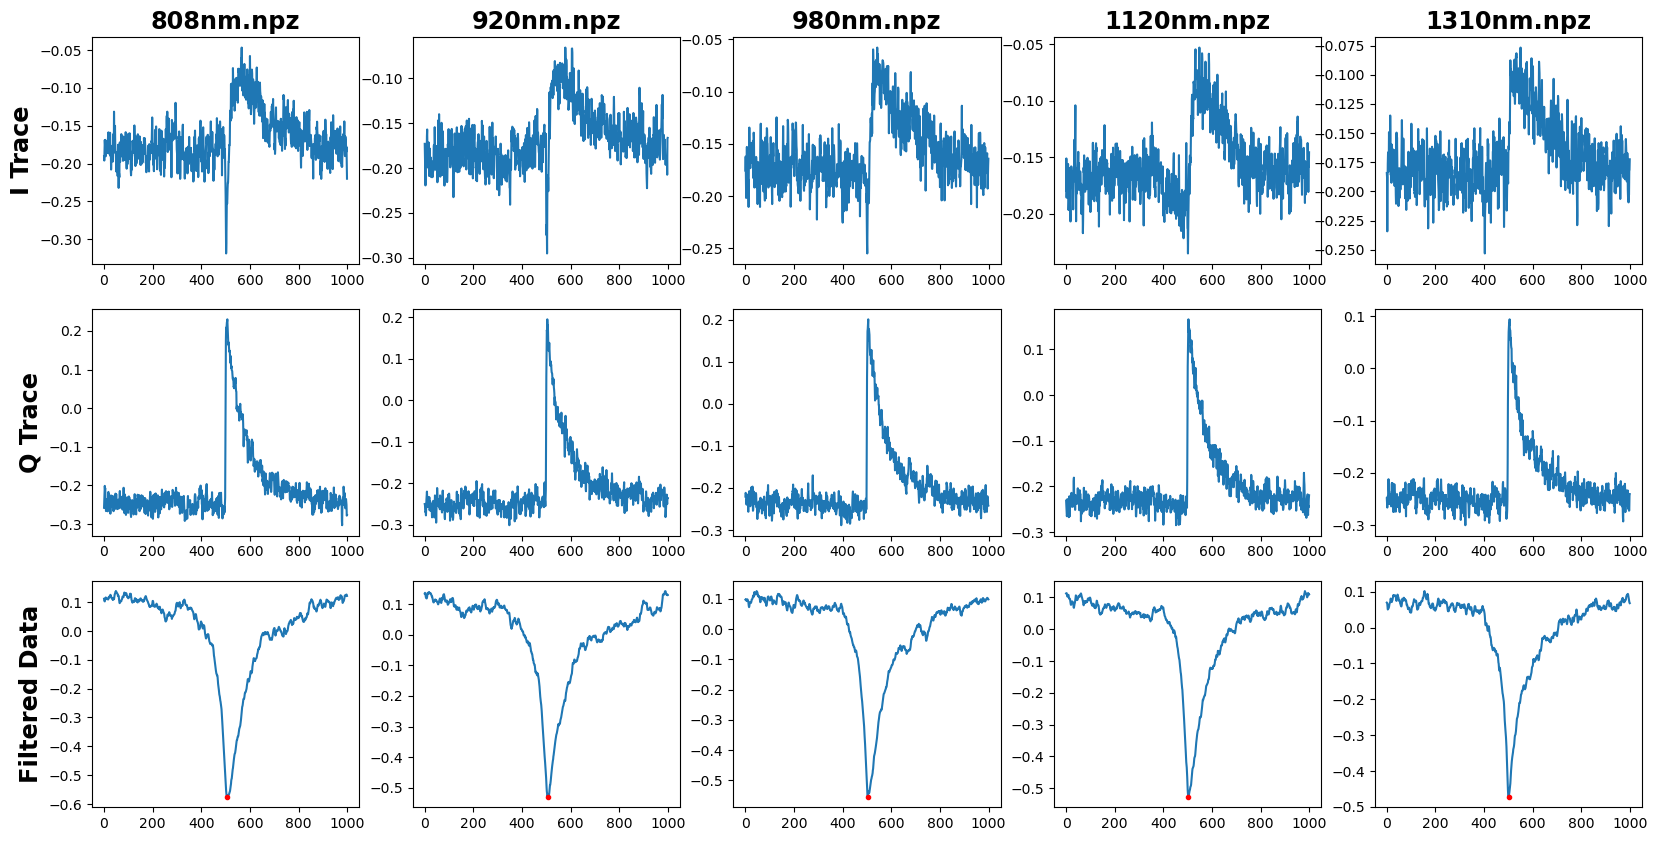

In [ ]:
#Plot first pulse in i_trace, q_trace, and filtered_data for each provided wavelength
t = np.arange(1000) #get time axis in terms of number of points to see what a reasonable estimate for n_pts is
fig, ax = plt.subplots(3,len(fnames), figsize = (20,10))
row = ["I Trace","Q Trace","Filtered Data"]
for i in range(3):
  ax[i,0].set_ylabel(row[i], rotation = 90, fontweight = "bold", size = 'xx-large')
for i in range(len(fnames)):
  ax[0,i].plot(t, i_trace[i*10000,:])
  ax[1,i].plot(t, q_trace[i*10000,:])
  ax[2,i].plot(t, filtered_data[i*10000,:])
  ax[2,i].plot(peak_indices[i*10000], filtered_data[i*10000,peak_indices[i*10000]], marker = '.', c= 'red')
  ax[0,i].set_title(fnames[i], fontweight = "bold", size = 'xx-large')

**Mapping Function**

In [ ]:
#optimize the comparison for the myriad number of functions in which a comparison like this one is used
@jit(nopython = True)
def comp(i_array, i_val, q_array, q_val):
    comp = (i_array-i_val)*(i_array-i_val) + (q_array - q_val)*(q_array - q_val) #multiplication is faster computationally than exponentiation
    return comp


def mapping(i_trace, q_trace, n_pts):
    #unravel the data to get an array of first values and last values (with 41255 values, since this is the number of good photons there are in our 50,000 photon dataset)
    first_val_i = i_trace[:,0].ravel()
    last_val_i = i_trace[:,n_pts].ravel()

    first_val_q  = q_trace[:,0].ravel()
    last_val_q = q_trace[:,n_pts].ravel()

    list_of_indices = deque()
    for i in range(len(first_val_i)):
        comparison = comp(last_val_i, first_val_i[i], last_val_q, first_val_q[i])
        index = np.where(comparison == min(comparison)) #now index is a list of number(s) between 0 and 49,999
        index = np.array(index).ravel() #takes array nestled within list and turns it into a 2d array, then unravels it into a 1D array
        index = int(index[0]) #if multiple indices satisfy the least squares comparison, just pick the first one
        list_of_indices.append(index)

    return list_of_indices


**Generating Mapping**

In [ ]:
n_pts = 100
index_mapping = mapping(i_trace, q_trace, n_pts)

Generating the least squares mapping and loading the data takes around ~3 minutes, so it is it's own cell.

**Synthetic Data Generation**<br>
This cell defines a function that generates representative noise, but at each discrete time step has a probability of `photon_prob` to insert a photon detection.


In [ ]:
'''
Function that takes an initial value in i, q, and label and returns the seed and pulse indices of the dataset closest to those initial values
'''
def insert_index(i_insertion_val,q_insertion_val,i_trace,q_trace, peak_indices,halfwidth,insert_peak=bool):
    '''
    Generate first_vals_i, first_vals_q, and first_vals_label if inserting noise
    '''
    if insert_peak == False:
        first_vals_i = i_trace[:,0].ravel()
        first_vals_q = q_trace[:,0].ravel()
        #generate comparison
        comparison = comp(first_vals_i, i_insertion_val, first_vals_q, q_insertion_val)


    '''
    Generate first_vals_i, first_vals_q, and first_vals_label if inserting a peak
    '''
    if insert_peak == True:
        peak_start_val_i = deque()
        peak_start_val_q = deque()

        #Get the starting value for each peak in I & Q space for the masked dataset
        for peak in peak_indices:
            val_i = i_trace[peak,peak_indices[peak] - halfwidth]
            val_q = q_trace[peak,peak_indices[peak] - halfwidth]

            peak_start_val_i.append(val_i)
            peak_start_val_q.append(val_q)

        peak_start_val_i = np.array(peak_start_val_i)
        peak_start_val_q = np.array(peak_start_val_q)

        #generate comparison
        comparison = comp(peak_start_val_i, i_insertion_val, peak_start_val_q, q_insertion_val)

    '''
    Figure out the index that minimizes the generated comparison
    '''

    index = np.where(comparison == comparison.min()) #now index is a list of number(s) between 0 and 41,254
    index = np.array(index).ravel() #takes array nestled within list and turns it into a 2d array, then unravels it into a 1D array

    #if there are multiple indices which satisfy the least squares comparison, select one at random. Ensure index is typecast from tuple to int
    if len(index) > 1:
        choice = np.random.randint(0,len(index))
        index = int(index[choice])
    else:
        index = int(index)

    return index


'''
Function that Generates Synthetic Data with or without labels
'''
def synthetic_data_gen(i_trace,q_trace, filtered_data, peak_indices, peak_heights, index_mapping, SampRate, TrainingTime, PhotonRate, n_pts, pulse_halfwidth,return_labels=bool):
    #Uses SampRate, TrainingTime, and PhotonRate to generate N_time_datapoints and photon_prob
    N_time_datapoints = int(SampRate*TrainingTime) #Number of datapoints based on the training time and sample rate
    photon_prob = PhotonRate/SampRate #The probability that a photon is incident at a given time_datapoint
    data_size = len(i_trace) #total number of photons in the dataset

    #Initializing arrays to return
    photon_energy = np.zeros(N_time_datapoints)
    prob_incident = np.zeros(N_time_datapoints)
    i_train = np.zeros(N_time_datapoints)
    q_train = np.zeros(N_time_datapoints)

    #randomly initializing the index
    pos = 0
    index = np.random.randint(data_size) #choose a random pulse
    while pos <= N_time_datapoints - n_pts:
        #If not inserting peak, continue stitching together noise
        i_train[pos:pos+n_pts] = i_trace[index_mapping[index], 0:n_pts]
        q_train[pos:pos+n_pts] = q_trace[index_mapping[index], 0:n_pts]
        photon_energy[pos:pos+n_pts] = filtered_data[index_mapping[index], 0:n_pts]
        index = index_mapping[index]
        pos += n_pts

        #Generates a random number drawn from a uniform distribution over [0,1) and if it's less than or equal to the probability, insert a peak. It also ensures there is enough space left in the generated data to insert a pulse
        if np.random.rand() <= photon_prob*n_pts and pos <= N_time_datapoints - pulse_halfwidth*2:
            #finding insertion values
            i_insertion_val = i_train[pos-1]
            q_insertion_val = q_train[pos-1]

            #finding seed and pulse insert index for peak insertion
            insertion_index = insert_index(i_insertion_val, q_insertion_val, i_trace, q_trace, peak_indices, pulse_halfwidth, insert_peak = True)

            #Error checking to ensure pulse is sufficiently centered to grab a full halfwidth on either side of it. If it fails this check, returns to the beginning of the loop and does not place a pulse
            pind = peak_indices[insertion_index]
            if pind < pulse_halfwidth or pind > np.shape(i_trace)[1] - pulse_halfwidth:
                continue

            #Error checking to ensure the peak_index actually corresponds with the minimum value in filtered_data:
            pmax = peak_heights[insertion_index]
            if pmax != min(filtered_data[insertion_index]):
                continue

            #inserting peak
            i_train[pos:pos+pulse_halfwidth*2] = i_trace[insertion_index, pind-pulse_halfwidth:pind + pulse_halfwidth]
            q_train[pos:pos+pulse_halfwidth*2] = q_trace[insertion_index, pind-pulse_halfwidth:pind + pulse_halfwidth]
            photon_energy[pos:pos+pulse_halfwidth*2] = filtered_data[insertion_index, pind-pulse_halfwidth:pind + pulse_halfwidth]
            prob_incident[pos+pulse_halfwidth] = 1
            pos += pulse_halfwidth*2

            #function parameters for inserting data on the other side of the peak
            i_insertion_val = i_train[pos-1]
            q_insertion_val = q_train[pos-1]

            #find the index with smallest discontinuity on the peak's tail for insertion of subsequent data
            index = insert_index(i_insertion_val, q_insertion_val, i_trace, q_trace, peak_indices, pulse_halfwidth, insert_peak = False)

            continue

    if return_labels == True:
        label = prob_incident, photon_energy
        return i_train, q_train, label
    elif return_labels == False:
        return i_train, q_train

'''
Generating Synthetic Data Using the Functions defined above
'''
#generating training data for display
pulse_halfwidth = 400
SampRate = 2000000     # Sample rate is 2 MHz
TrainingTime = 0.1     # Training data set length in sec
PhotonRate = 1000.0    # Photon Arrival rate in photons/sec
i_train, q_train, label = synthetic_data_gen(i_trace,q_trace, filtered_data, peak_indices, peak_heights, index_mapping, SampRate, TrainingTime, PhotonRate, n_pts, pulse_halfwidth,return_labels=True)



**Synthetic Data and Power Spectral Density Visualization**

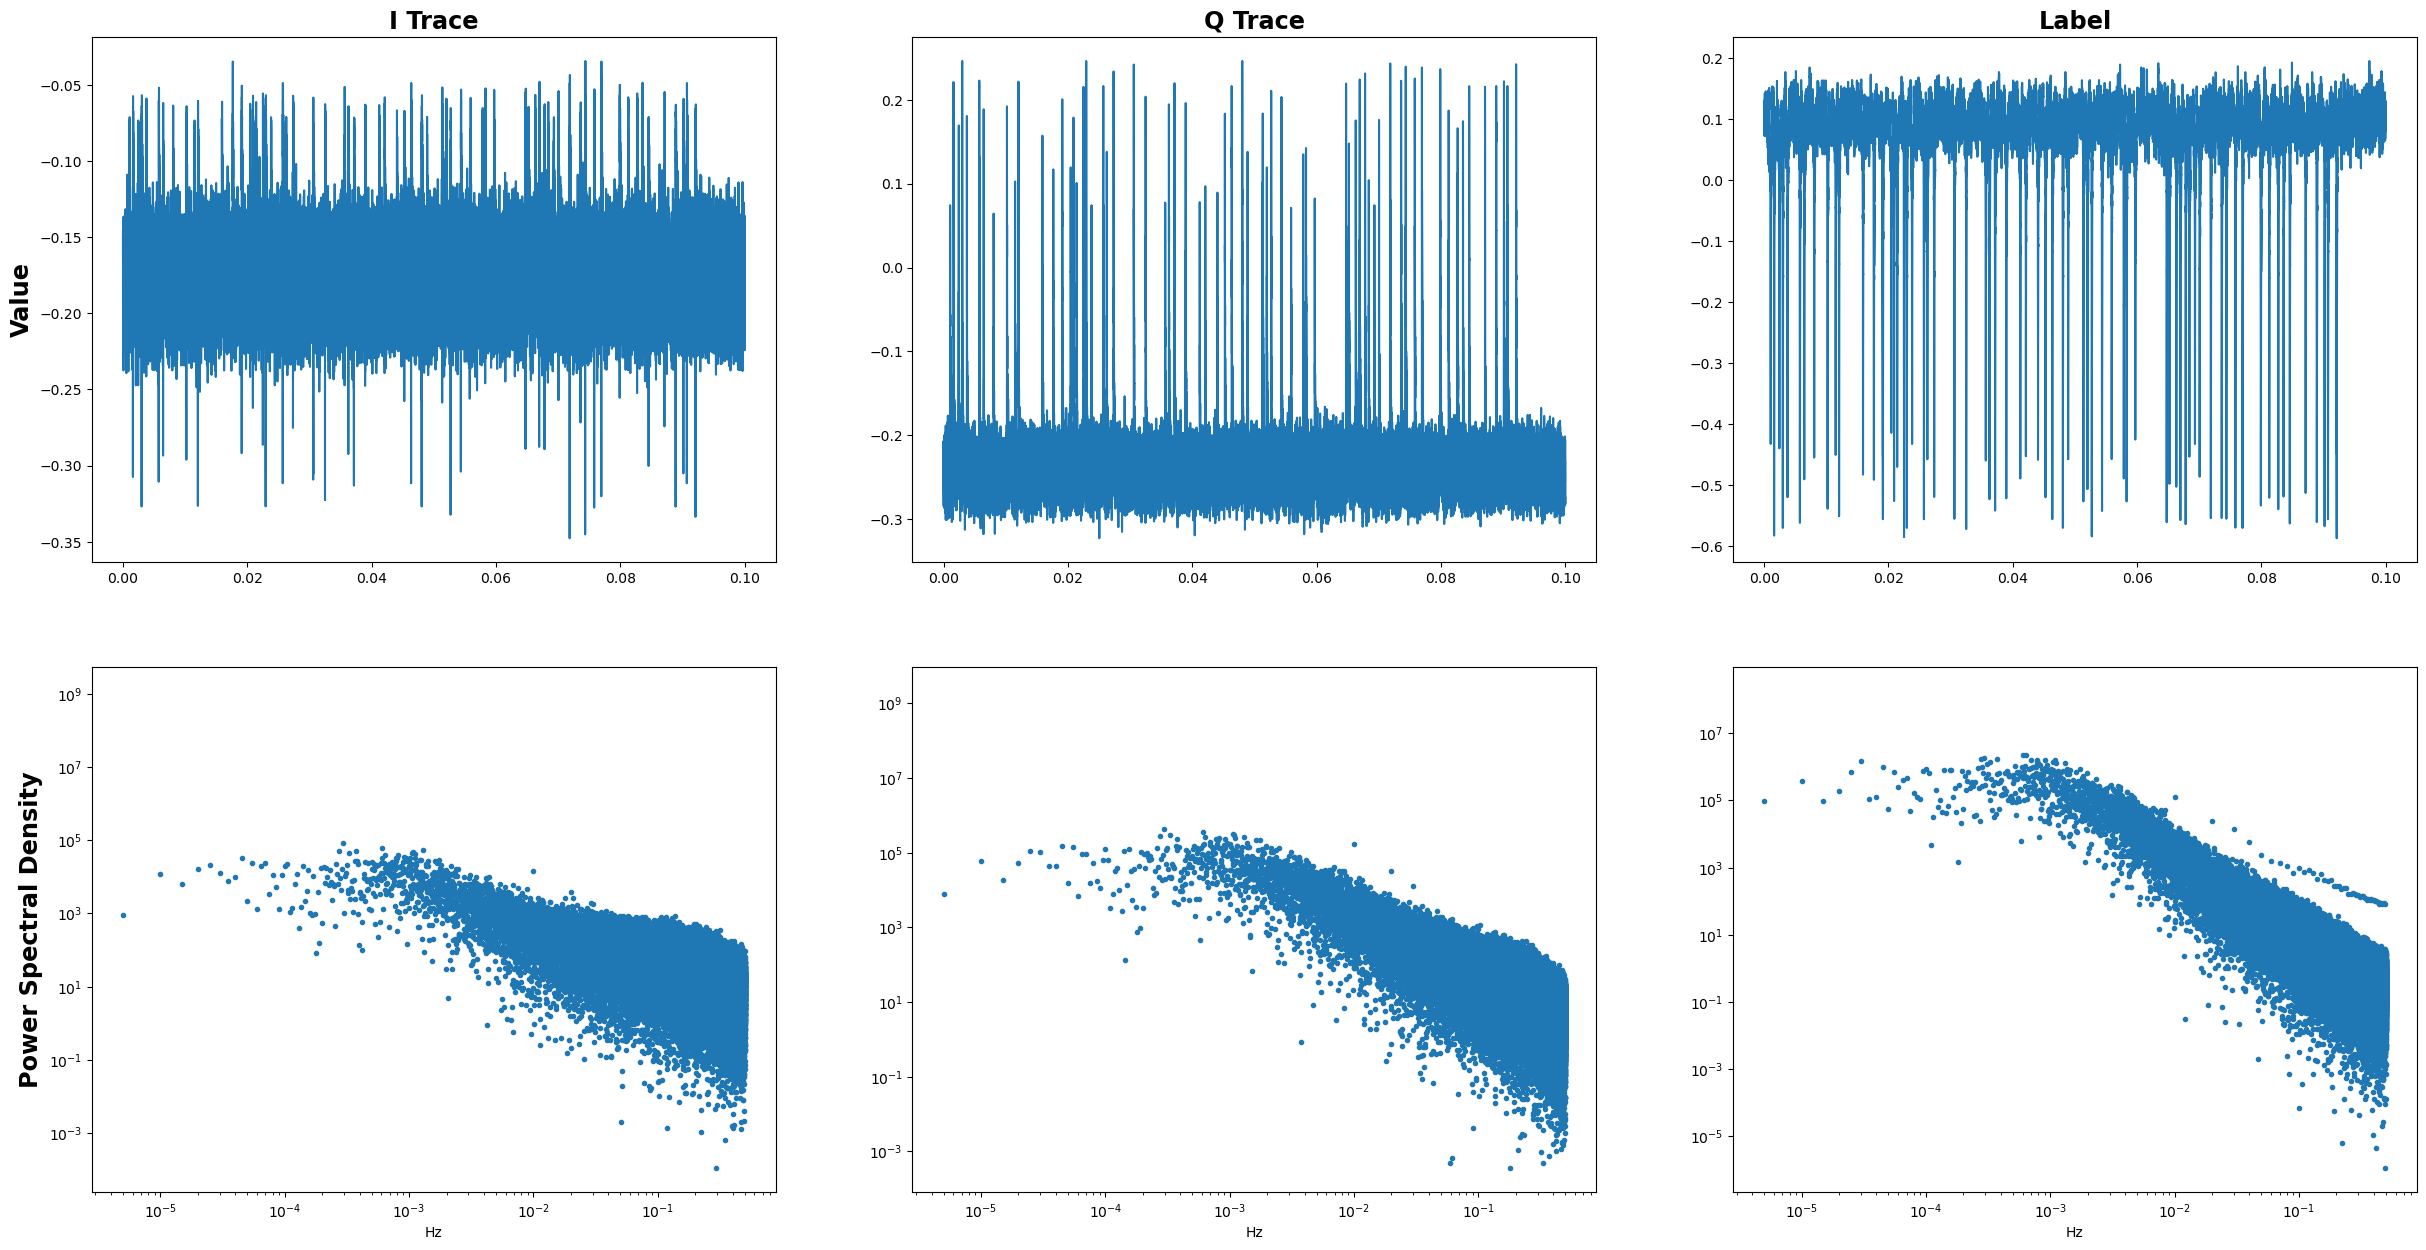

In [ ]:
fig, ax = plt.subplots(2,3,figsize = (30,15))

photon_prob, photon_energy = label
N_time_datapoints = int(SampRate*TrainingTime) #Number of datapoints based on the training time and sample rate
time = np.linspace(0,TrainingTime,N_time_datapoints)

#Fourier Transform stuff
freq = np.fft.fftfreq(len(time))
powerspec_i = np.abs(np.fft.fft(i_train))**2
powerspec_q = np.abs(np.fft.fft(q_train))**2
powerspec_label = np.abs(np.fft.fft(photon_energy))**2


#Row labels
ax[0,0].set_ylabel("Value",fontweight = "bold",size = 'xx-large', rotation = 90)
ax[1,0].set_ylabel("Power Spectral Density",fontweight = "bold",size = 'xx-large', rotation = 90)

#Column labels
ax[0,0].set_title("I Trace",fontweight = "bold", size = 'xx-large')
ax[0,1].set_title("Q Trace",fontweight = "bold", size = 'xx-large')
ax[0,2].set_title("Label",fontweight = "bold", size = 'xx-large')

#x_label + x_lims
for j in range(3):
    ax[1,j].set_xlabel("Hz")

#I_trace
ax[0,0].plot(time, i_train)
ax[1,0].loglog(freq,powerspec_i, linestyle = '', marker = '.')

#Q_trace
ax[0,1].plot(time, q_train)
ax[1,1].loglog(freq,powerspec_q, linestyle = '', marker = '.')

#Photon Energy
ax[0,2].plot(time,photon_energy)
ax[1,2].loglog(freq,powerspec_label, linestyle = '', marker = '.') #I don't think there's any physical meaning to be pulled from this plot

plt.show()

# **Model Training**
Run these cells if you are training a new model!

**Data Processing**

In [ ]:
def normalize(data):
  mean = np.mean(data)
  std = np.std(data)
  return (data-mean)/(std)

def make_Dataset(batch_size, window_shape, I, Q, label = None):
    #only normalize the input data so the target output doesn't get warped, and create rolling windows
    I = view_as_windows(normalize(I), window_shape)
    Q = view_as_windows(normalize(Q),window_shape)

    #creating windows for the data
    data_windows = tf.convert_to_tensor(np.stack((I,Q), axis = -1), dtype = tf.float32)

    #using optional argument to build Datasets with/without labels & time if they are/aren't passed
    if label is None:
        dataset = tf.data.Dataset.from_tensor_slices(data_windows)
    else:
        #converting label to tensor
        energy_label = tf.convert_to_tensor(label[1][int(window_shape/2):-int(window_shape/2)], dtype = tf.float32)

        #constructing dataset tuple
        dataset = tf.data.Dataset.from_tensor_slices((data_windows, energy_label))

    #batching datasets
    dataset = dataset.batch(batch_size)

    return dataset


#defining hyperparameters
batch_size = 100       # How many values before the model updates parameters and checks against the validation set
window_shape = 149     # MUST BE AN ODD NUMBER OR THE ROLLING WINDOW WILL NOT BE SYMMETRIC AND THERE WILL BE PROBLEMS
vector_size = 2        # This indicates the dimension of inputs to the model (currently dimensions of [I, Q])
pulse_halfwidth = 400  # How many points on either side of the peak index to grab
SampRate = 2000000     # Sample rate is 2 MHz
TrainingTime = 0.4     # Training data set length in sec
PhotonRate = 1000.0    # Photon Arrival rate in photons/sec
n_pts = 100            # How often during synthetic data generation will the model attempt to stitch noise/photons from a new wavelength source


#Training Dataset
train_fnames = ['808nm.npz','980nm.npz','1310nm.npz'] #Load wavelengths to train on
i_trace, q_trace, filtered_data, peak_indices, peak_heights = load_spectra(datadir, train_fnames)
index_mapping = mapping(i_trace, q_trace, n_pts)
i_train, q_train, label_train = synthetic_data_gen(i_trace,q_trace, filtered_data, peak_indices, peak_heights, index_mapping, SampRate, TrainingTime, PhotonRate, n_pts, pulse_halfwidth,return_labels=True)
dataset_train = make_Dataset(batch_size, window_shape, i_train, q_train, label_train)


#Validation Dataset
val_fnames = ['920nm.npz'] #Load wavelength(s) to generate a validation set from
i_trace, q_trace, filtered_data, peak_indices, peak_heights = load_spectra(datadir, val_fnames)
index_mapping = mapping(i_trace, q_trace, n_pts)
i_val, q_val, label_val = synthetic_data_gen(i_trace,q_trace, filtered_data, peak_indices, peak_heights, index_mapping, SampRate, TrainingTime, PhotonRate, n_pts, pulse_halfwidth,return_labels=True)
dataset_val = make_Dataset(batch_size, window_shape, i_val, q_val, label_val)

**Blank Model Creation**

In [ ]:
implicit_input_shape = (window_shape, vector_size)

#create the energy prediction
model = tf.keras.Sequential(
[
    #Input Layer
    tf.keras.Input(shape = implicit_input_shape),

    #Convolutional Network
    tf.keras.layers.Conv1D(filters = 128, kernel_size = 5, strides = 1, padding = 'same',activation = 'gelu'),
    tf.keras.layers.MaxPooling1D(pool_size = 2, padding = 'same', data_format = 'channels_last'),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 5, strides = 1, padding = 'same',activation = 'gelu'),
    tf.keras.layers.MaxPooling1D(pool_size = 2, padding = 'same', data_format = 'channels_last'),

    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1, padding = 'same',activation = 'gelu'),
    tf.keras.layers.MaxPooling1D(pool_size = 5, padding = 'same', data_format = 'channels_last'),


    #LSTM Network
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences = True)),

    #Dense Layer
    tf.keras.layers.Dense(32, activation = 'relu'),

    #Output Layer + Flattening
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)
    ])


#compile the model with the optimizer
model.compile(
  optimizer = tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.MeanSquaredError()
  )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 149, 128)          1408      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 75, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 75, 64)            41024     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 38, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 38, 32)            10272     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 8, 32)            0

**Training Model**

In [ ]:
#model_checkpoint and early stopping callbacks
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("saved_model.h5", save_best_only=True)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7*10**(epoch/10)) #figure out optimal learning rate
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience= 5)

#relevant hyperparameter
epochs = 100

#fit model
history = model.fit(dataset_train, epochs=epochs,validation_data=dataset_val, callbacks=[model_checkpoint, lr_schedule, early_stopping])
np.save("my_history.npy", history.history)

Epoch 1/100
7999/7999 [==============================] - 1455s 180ms/step - loss: 0.0124 - val_loss: 0.0113 - lr: 1.0000e-07
Epoch 2/100
7999/7999 [==============================] - 1405s 176ms/step - loss: 0.0094 - val_loss: 0.0080 - lr: 1.2589e-07
Epoch 3/100
7999/7999 [==============================] - 1447s 181ms/step - loss: 0.0063 - val_loss: 0.0051 - lr: 1.5849e-07
Epoch 4/100
7999/7999 [==============================] - 1718s 215ms/step - loss: 0.0045 - val_loss: 0.0038 - lr: 1.9953e-07
Epoch 5/100
7999/7999 [==============================] - 2228s 279ms/step - loss: 0.0032 - val_loss: 0.0025 - lr: 2.5119e-07
Epoch 6/100
7999/7999 [==============================] - 2084s 260ms/step - loss: 0.0021 - val_loss: 0.0017 - lr: 3.1623e-07
Epoch 7/100
7999/7999 [==============================] - 2228s 279ms/step - loss: 0.0015 - val_loss: 0.0014 - lr: 3.9811e-07
Epoch 8/100
7999/7999 [==============================] - 2089s 261ms/step - loss: 0.0013 - val_loss: 0.0012 - lr: 5.0119e-07


**Training Metrics**

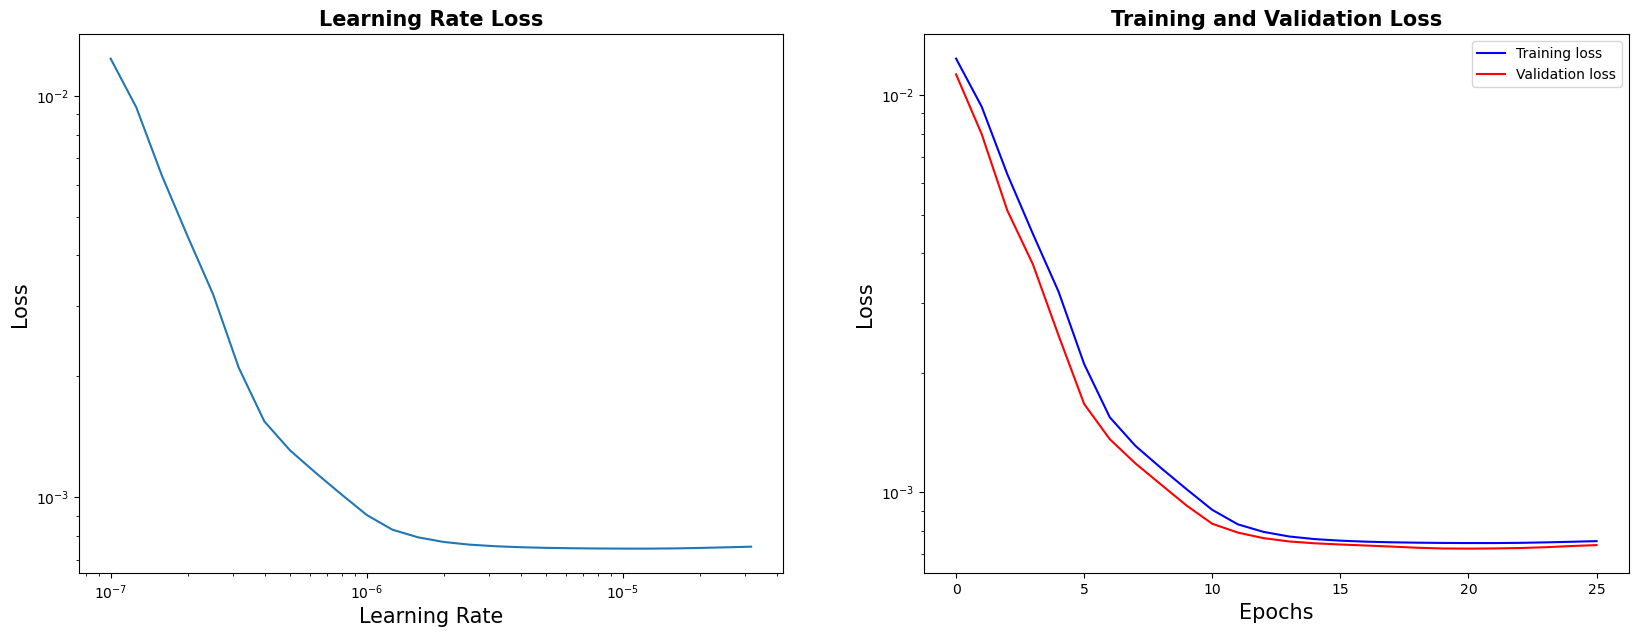

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (20,7))


#display Loss as a function of Learning Rate
ax[0].loglog(history.history["lr"], history.history["loss"])
ax[0].set_xlabel("Learning Rate", fontsize = 15)
ax[0].set_title("Learning Rate Loss", fontsize = 15, fontweight = 'bold')
ax[0].set_ylabel("Loss", fontsize = 15)


#Display Loss as a function of epochs
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(loss))
ax[1].semilogy(epochs, loss, c="b", label="Training loss")
ax[1].semilogy(epochs, val_loss,c="r", label="Validation loss")
ax[1].set_title("Training and Validation Loss", fontsize = 15, fontweight = 'bold')
ax[1].set_xlabel("Epochs", fontsize = 15)
ax[1].set_ylabel("Loss", fontsize = 15)
ax[1].legend()
plt.show()

# **Model Loading**
Run these cells if you are loading an already existing model!

**Hyperparameters** <br>
Port hyperparameters used in training the model

In [ ]:
window_shape = 149 #This hyperparameter describes the hyperrectangle for the rolling window view
batch_size = 100 #This hyperparameter describes how many Dataset slices the model will look at before adjusting model parameters
vector_size = 2 #this indicates the dimension of inputs to the model (currently dimensions of [I, Q])
pulse_halfwidth = 400  #How many points on either side of the peak index to grab
SampRate = 2000000     # Sample rate is 2 MHz
PhotonRate = 1000.0    # Photon Arrival rate in photons/sec

#Need to define the following functions to load data into the model in the same way in which it was trained
def normalize(data):
  mean = np.mean(data)
  std = np.std(data)
  return (data-mean)/(std)

def make_Dataset(batch_size, window_shape, I, Q, label = None):
    #only normalize the input data so the target output doesn't get warped, and create rolling windows
    I = view_as_windows(normalize(I), window_shape)
    Q = view_as_windows(normalize(Q),window_shape)

    #creating windows for the data
    data_windows = tf.convert_to_tensor(np.stack((I,Q), axis = -1), dtype = tf.float32)

    #using optional argument to build Datasets with/without labels & time if they are/aren't passed
    if label is None:
        dataset = tf.data.Dataset.from_tensor_slices(data_windows)
    else:
        #converting label to tensor
        energy_label = tf.convert_to_tensor(label[1][int(window_shape/2):-int(window_shape/2)], dtype = tf.float32)

        #constructing dataset tuple
        dataset = tf.data.Dataset.from_tensor_slices((data_windows, energy_label))

    #batching datasets
    dataset = dataset.batch(batch_size)

    return dataset


**Loading Model**

In [ ]:
model = tf.keras.models.load_model("saved_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 149, 128)          1408      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 75, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 75, 64)            41024     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 38, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 38, 32)            10272     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 8, 32)            0

**Displaying Training Metrics**

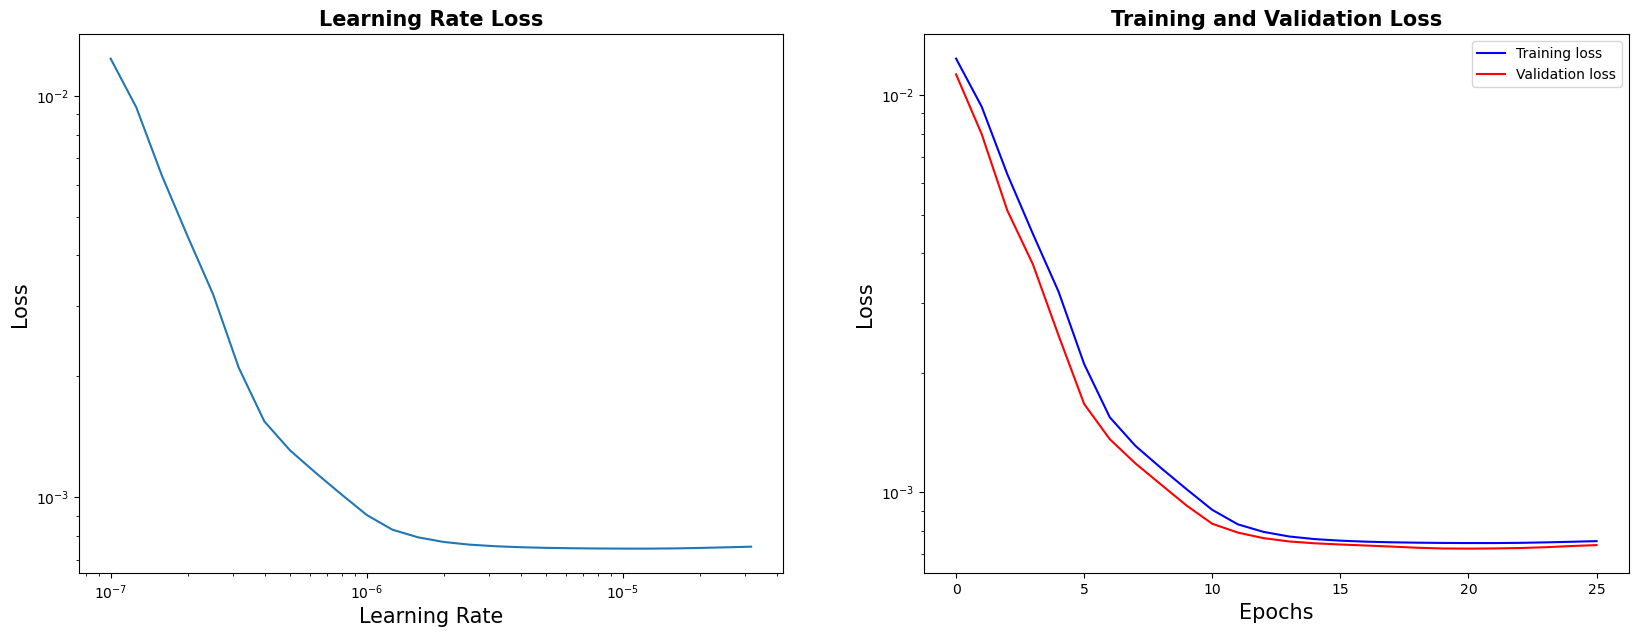

In [ ]:
history = np.load("my_history.npy", allow_pickle = True).item()
fig, ax = plt.subplots(1,2, figsize = (20,7))


#display Loss as a function of Learning Rate
ax[0].loglog(history["lr"], history["loss"])
ax[0].set_xlabel("Learning Rate", fontsize = 15)
ax[0].set_title("Learning Rate Loss", fontsize = 15, fontweight = 'bold')
ax[0].set_ylabel("Loss", fontsize = 15)


#Display Loss as a function of epochs
loss = history["loss"]
val_loss = history["val_loss"]
epochs = range(len(loss))
ax[1].semilogy(epochs, loss, c="b", label="Training loss")
ax[1].semilogy(epochs, val_loss,c="r", label="Validation loss")
ax[1].set_title("Training and Validation Loss", fontsize = 15, fontweight = 'bold')
ax[1].set_xlabel("Epochs", fontsize = 15)
ax[1].set_ylabel("Loss", fontsize = 15)
ax[1].legend()
plt.show()

# **Model Evaluation**

**Defining `model_predictions` Function**<br>
The `model_predictions` function generates evaluation data using the `synthetic_data_gen` function defined under the **Data Generation** heading. It then generates and returns model predictions based on the evaluation data generated in the function call.

In [ ]:
def model_predictions(model, i_trace,q_trace, filtered_data, peak_indices, peak_heights, index_mapping, SampRate, TrainingTime, PhotonRate, n_pts, pulse_halfwidth, return_labels = bool):
    #generating evaluation data
    i_eval, q_eval, label_eval = synthetic_data_gen(i_trace, q_trace, filtered_data, peak_indices, peak_heights, index_mapping, SampRate, TrainingTime, PhotonRate, n_pts, pulse_halfwidth,return_labels=True)
    N_time_datapoints = int(SampRate*TrainingTime)

    #Need to create the evaluation data the same way as the training data, using previously defined functions
    dataset_eval = make_Dataset(batch_size, window_shape, i_eval, q_eval, None)

    #Generating Model Predictions
    output = model.predict(dataset_eval)

    #the 1 dimensional model prediction is at each index the predicted energy of a photon multiplied by the probability that there is indeed a photon incident
    model_prediction = np.squeeze(output)

    if return_labels == True:
        return model_prediction, label_eval
    elif return_labels == False:
        return model_prediction

**Generating a Rescaling Factor**<br>
Model predictions need to be rescaled by a constant factor in order to be compared to label peaks. This `rescaling_factor` can be estimated by eye, but ideally, we want to determine the rescaling factor quantitatively for any set of data that the model might be asked to make predictions upon. In the next code cell, we generate evaluation data and minimize the `scaling_factor` function(which returns the least squares difference between the model's predicted peaks and the label's peaks) to obtain the best fit `rescaling_factor`. We then perform bootstrap resampling by redoing the previous step multiple times in order to recover a bootstrapped `rescaling_factor` and it's uncertainty. This bootstrapped resampled `rescaling_factor` can then be applied to all predictions made by the model. Expect this cell to take around 10 minutes to run with 50 iterations.

In [ ]:
temporal_shift_range = 250 #The number of values on either side of label peaks we will look for a temporally shifted peak

#Defining the function to minimize to obtain the scaling factor for each generated evaluation dataset
def scaling_factor(rescaling_factor, model_prediction, label_eval):
    #when the label does not equal zero, a photon is incident
    prob_eval, energy_eval = label_eval
    peak_indices = np.squeeze(np.asarray(np.where(prob_eval != 0)))
    lstsq = 0

    #We want to determine the appropriate scaling factor by minimizing the least squares difference of the model predictions and label values for photon energy
    for peak in peak_indices:
        label_peak = energy_eval[peak]
        prediction_range = model_prediction[peak - temporal_shift_range: peak + temporal_shift_range]
        model_peak = min(prediction_range) #pick the minimum value in the prediction because that's where the
        lstsq += (model_peak*rescaling_factor - label_peak)**2 #calculate lstsq value(to be minimized)

    return lstsq

#Passing the scaling_factor function to the minimizing function
def find_best_rescaling_factor(model_prediction, label_eval):
    guess = np.random.rand() #Since we are only fitting one parameter, our initial guess shouldn't matter
    rescaling_factor = minimize(scaling_factor, guess, args=(model_prediction, label_eval), method = "Powell").x
    return rescaling_factor

#Defining the function to minimize to obtain the temporal shift factor for each generated evaluation dataset
def find_best_temporal_shift(model_prediction, label_eval):
    #when the label does not equal zero, a photon is incident
    prob_eval, energy_eval = label_eval
    peak_indices = np.squeeze(np.asarray(np.where(prob_eval != 0)))
    temporal_shift = []

    #We want to determine the appropriate temporal shift by averaging all the temporal shifts over the entire model
    for peak in peak_indices:
        label_peak = energy_eval[peak]
        prediction_range = model_prediction[peak - temporal_shift_range: peak + temporal_shift_range]
        temporal_shift.append(np.squeeze(np.asarray(np.where(prediction_range == min(prediction_range)))) - len(prediction_range)/2)

    #calculating statistics
    temporal_shift = np.asarray(temporal_shift)
    avg_temporal_shift = np.mean(temporal_shift)
    sigma_temporal_shift = np.std(temporal_shift)

    return avg_temporal_shift, sigma_temporal_shift

eval_TrainingTime = 0.015 #even if training the model on more than 0.015 second of training time, evaluate it on 0.015 second of training time because it's faster
N_time_datapoints = int(SampRate*eval_TrainingTime)
time_eval = np.linspace(0,TrainingTime,N_time_datapoints)

#Performing bootstrap resampling: When generating synthetic data with a training time of 0.01 seconds, model_predictions took about 10 seconds per iteration(expect this cell to be computationally expensive)
num_iter = 50
bstrap_rescaling_list = deque()
bstrap_temporal_avg_list = deque()
bstrap_temporal_sigma_list = deque()
for i in range(num_iter):
    bstrap_model_prediction, bstrap_label = model_predictions(model, i_trace,q_trace, filtered_data, peak_indices, peak_heights, index_mapping, SampRate, eval_TrainingTime, PhotonRate, n_pts, pulse_halfwidth, return_labels = True)

    #bstrapping rescaling factor
    rescaling_factor_i = find_best_rescaling_factor(bstrap_model_prediction, bstrap_label)
    bstrap_rescaling_list.append(rescaling_factor_i)

    #bstrapping temporal shift
    avg_temporal_shift_i, sigma_temporal_shift_i  = find_best_temporal_shift(bstrap_model_prediction, bstrap_label)
    bstrap_temporal_avg_list.append(avg_temporal_shift_i)
    bstrap_temporal_sigma_list.append(sigma_temporal_shift_i)

#Rescaling Factor
bstrap_rescaling_factor = np.mean(bstrap_rescaling_list)
sigma_rescaling_factor = np.std(bstrap_rescaling_list)
print(f"Using bootstrap resampling with {num_iter} iterations generates a rescaling factor of {bstrap_rescaling_factor:.3f} ± {sigma_rescaling_factor:.3f}")

#Temporal Shift
bstrap_temporal_shift = np.mean(bstrap_temporal_avg_list)
sigma_temporal_shift = np.mean(bstrap_temporal_sigma_list)
print(f"Using bootstrap resampling with {num_iter} iterations generates a temporal shift of {bstrap_temporal_shift:.3f} ± {sigma_temporal_shift:.3f}")

299/299 [==============================] - 12s 40ms/step
Using bootstrap resampling with 50 iterations generates a rescaling factor of 1.060 ± 0.062
Using bootstrap resampling with 50 iterations generates a temporal shift of -75.808 ± 3.220


A small range of rescaling factors from multiple iterations of model predictions on randomly created evaluation data during bootstrapping implies that the model is consistently 'off' the true values by roughly the same amount. This corresponds to the uncertainty on the bootstrap resampled rescaling factor, which therefore gives an indication of how precise (and therefore how good) the model is.

**Model Prediction + Scaling Factor Generation**

In [ ]:
prediction, label_eval = model_predictions(model, i_trace,q_trace, filtered_data, peak_indices, peak_heights, index_mapping, SampRate, eval_TrainingTime, PhotonRate, n_pts, pulse_halfwidth, return_labels = True)
best_rescaling_factor = find_best_rescaling_factor(prediction, label_eval)
prob_eval, energy_eval = label_eval

299/299 [==============================] - 13s 43ms/step


**Prediction Visualization**

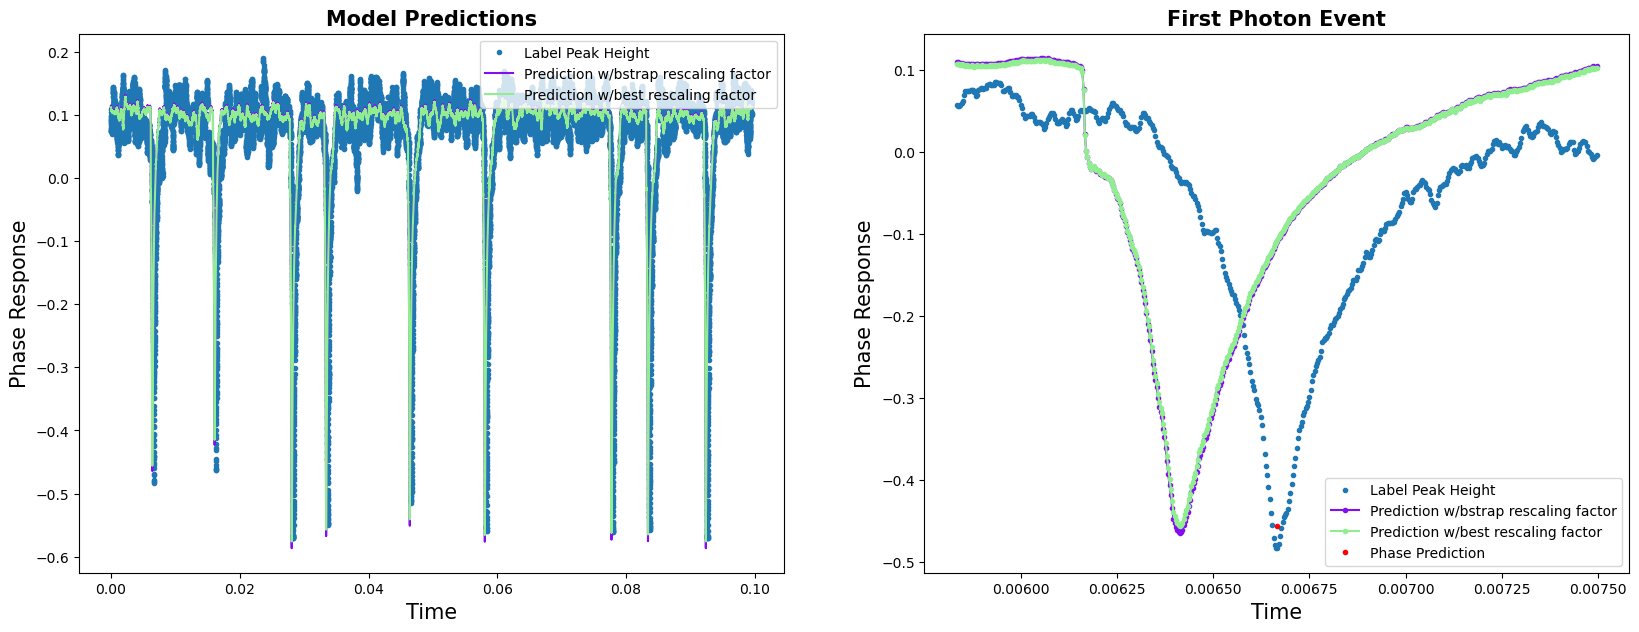

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (20,7))

#Plotting Model Predictions
ax[0].plot(time_eval[0:N_time_datapoints - window_shape],energy_eval[0:N_time_datapoints - window_shape],label = "Label Peak Height", linestyle = '', marker= '.')
ax[0].plot(time_eval[0:N_time_datapoints - window_shape],prediction[0:N_time_datapoints - window_shape]*bstrap_rescaling_factor,label = "Prediction w/bstrap rescaling factor", c = '#850ef0')
ax[0].plot(time_eval[0:N_time_datapoints - window_shape],prediction[0:N_time_datapoints - window_shape]*best_rescaling_factor,label = "Prediction w/best rescaling factor", c = 'lightgreen')
ax[0].set_ylabel("Phase Response", fontsize = 15)
ax[0].set_xlabel("Time", fontsize = 15)
ax[0].set_title("Model Predictions", fontweight = 'bold', fontsize = 15)
ax[0].legend(loc = 'upper right')

#Zooming in on the first Photon Detection
first_photon = np.squeeze(np.asarray(np.where(prob_eval != 0)))[0] #gets index of first photon detection
nearest_peak = min(prediction[first_photon - temporal_shift_range: first_photon + temporal_shift_range]) #gets value of the nearest peak
ax[1].plot(time_eval[first_photon - temporal_shift_range:first_photon + temporal_shift_range],energy_eval[first_photon - temporal_shift_range:first_photon + temporal_shift_range],label = "Label Peak Height", linestyle = '', marker= '.')
ax[1].plot(time_eval[first_photon - temporal_shift_range:first_photon + temporal_shift_range],prediction[first_photon - temporal_shift_range:first_photon + temporal_shift_range]*bstrap_rescaling_factor,marker = '.',label = "Prediction w/bstrap rescaling factor",c = '#850ef0')
ax[1].plot(time_eval[first_photon - temporal_shift_range:first_photon + temporal_shift_range],prediction[first_photon - temporal_shift_range:first_photon + temporal_shift_range]*best_rescaling_factor,marker = '.',label = "Prediction w/best rescaling factor", c = 'lightgreen')
ax[1].plot(time_eval[first_photon], nearest_peak*best_rescaling_factor, label = "Phase Prediction", linestyle = '', marker = '.', color = 'red')
ax[1].set_ylabel("Phase Response", fontsize = 15)
ax[1].set_xlabel("Time", fontsize = 15)
ax[1].set_title("First Photon Event", fontweight = 'bold', fontsize = 15)
ax[1].legend()

plt.show()


# **Spectra and Curve Fitting**

**Energy Histogram Functions** <br>
Generating the histogram of energies from the label and the predictions from the model, based on an arbitrary input spectra. If they are indistinguishable, it implies that the machine learning model is an appropriate tool for data analysis for this system.

In [ ]:
def gen_hist_data (TrainingTime, i_trace, q_trace, filtered_data, peak_indices, peak_heights, index_mapping):
    #For reasons I don't fully understand, joblib struggles with naming conflicts if you make function calls to other functions that have objects with identical names (or something)
    #After a lot of trial and error but mostly error, I took the contents of the model_predictions function (defined above), and copy + pasted it here. It works. Don't question it.
    i_eval, q_eval, label_eval = synthetic_data_gen(i_trace, q_trace, filtered_data, peak_indices, peak_heights, index_mapping, SampRate, TrainingTime, PhotonRate, n_pts, pulse_halfwidth,return_labels=True)
    N_time_datapoints = int(SampRate*TrainingTime)

    #Need to create the evaluation data the same way as the training data, using previously defined functions
    dataset_eval = make_Dataset(batch_size, window_shape, i_eval, q_eval, None)

    #Generating Model Predictions
    model = tf.keras.models.load_model("saved_model.h5") #I also have to load the model explicitly in this function or joblib freaks out. Why? No clue.
    output = model.predict(dataset_eval)

    #the 1 dimensional model prediction is at each index the predicted energy of a photon multiplied by the probability that there is indeed a photon incident
    prediction = np.squeeze(output)

    #####################################################################
    #everything above this comment is from the model_predictions function
    true_prob, true_energy = label_eval

    #acquiring peak values for the label
    index = np.where(true_prob == 1)
    true_peaks = np.asarray(true_energy[index])

    #acquiring peak values for the prediction
    prediction = prediction*bstrap_rescaling_factor
    pred_indices, min = find_peaks(-1*prediction,height = 0.2 ,distance = temporal_shift_range) #multiplied by negative one to find minima instead of maxima
    pred_peaks = np.asarray(-1*min['peak_heights']) #find_peaks creates an array with peak_indices and a dictionary with peak_heights as a key

    return true_peaks, pred_peaks

#Choose wavelengths for which to make data and generate predictions
def spectrum_hist(datadir,fname, parallel = bool):
    i_trace, q_trace, filtered_data, peak_indices, peak_heights = load_spectra(datadir, fname)
    index_mapping = mapping(i_trace, q_trace, n_pts)
    TrainingTime = 0.5

    if parallel == False:
        hist_data = [gen_hist_data(TrainingTime, i_trace, q_trace, filtered_data, peak_indices, peak_heights, index_mapping) for i in range(10)] #generate 5 seconds worth of data

    elif parallel == True:
        hist_data = Parallel(n_jobs = -1, verbose = 10)(delayed(gen_hist_data)(TrainingTime, i_trace, q_trace, filtered_data, peak_indices, peak_heights, index_mapping) for i in range(20)) #Generates 10 seconds worth of data (quickly) but bricks my laptop

    #unpacking values
    true_peaks_hist = []
    pred_peaks_hist = []
    for process in hist_data:
        true_peaks, pred_peaks = process
        true_peaks_hist.extend(list(true_peaks))
        pred_peaks_hist.extend(list(pred_peaks))

    return true_peaks_hist, pred_peaks_hist


**Transformation from Phase Space to Electron Volts** <br>
Using Planck's formula, we can transform from wavelength to electron volts.
$$E = \frac{h \cdot c}{\lambda}$$

Using SVD, we can fit a second order polynomial to obtain a relationship between phase space $\phi$ and wavelength $\lambda$, and by extension, Energy.
$$E(\phi) = a_0 + a_1 \phi + a_2 \phi^2$$

$$\Phi \cdot a = E$$

$$
\begin{pmatrix}
1 & \phi_1 & \phi_1^2 \\
1 & \phi_2 & \phi_2^2 \\
1 & \phi_3 & \phi_3^2 \\
  & \vdots & \\
1 & \phi_n & \phi_n^2 \\
\end{pmatrix}
\begin{pmatrix}
a_0 \\
a_1 \\
a_2 \\  
\end{pmatrix}
=
\begin{pmatrix}
E(\phi_1) \\
E(\phi_2) \\
E(\phi_3) \\
\vdots   \\
E(\phi_n)
\end{pmatrix}
$$

In [ ]:
def phase_to_energy(phase_data, cal_fit_means, cal_energies):
    #setting up SVD
    a0 = np.ones(len(cal_fit_means))
    a1 = cal_fit_means
    a2 = cal_fit_means**2

    #matrix transpose because numpy interprets phi as made of row vectors rather than column vectors
    phi = np.array([a0,a1,a2]).T
    a_best = np.linalg.lstsq(phi,cal_energies,rcond=None)
    params = a_best[0]

    #casting so that an array can be returned for an arbitrary phase data shape
    a_0 = np.ones(np.shape(phase_data)) * params[0]
    a_1 = np.ones(np.shape(phase_data)) * params[1]
    a_2 = np.ones(np.shape(phase_data)) * params[2]

    #our final product!
    energy_data = a_0 + a_1*phase_data + a_2*phase_data**2

    return energy_data, params

@np.vectorize
def nm_to_ev(lambduh):
  return 1.24e3/lambduh #got this formula from https://www.sciencedirect.com/topics/engineering/plancks-constant

**Energy Resolution Calculation Function**

In [ ]:
def E_resolution(spectra, n_bins):
    density, bins = np.histogram(spectra, bins = n_bins, density = True)
    x = bins[0:-1] - 0.5*(bins[1]-bins[0])

    #return the corresponding pdf
    kernel = gaussian_kde(spectra)
    pdf = kernel(x)

    #Get the mean, FWHM, and Energy Resolution from the KDE fit to the histogram
    mu = x[np.where(pdf == max(pdf))]
    HM = max(pdf)/2
    HM_indices = np.where(np.diff(np.sign(pdf - HM)))[0]
    left_bound = np.where(np.diff(np.sign(x[HM_indices] - mu*np.ones(len(HM_indices)))))[0][0]
    FWHM = np.abs(x[HM_indices[left_bound]] - x[HM_indices[left_bound+1]])
    R = mu/FWHM

    return x, pdf, mu, R


**Phase Space to eV** <br>
This cell uses the `E_resolution` function defined above to fit the histogram of each provided spectra, then uses the results of those fits to obtain the input needed for the `phase_to_energy` function to be able to transform from phase space to eV.

In [ ]:
#reloading the masked data so that it's separated by wavelength
fnames = ['808nm.npz','920nm.npz','980nm.npz','1120nm.npz','1310nm.npz'] #Load all wavelengths for the calibration
sep_spectra = []
for photon in fnames:
    data = np.load(datadir+photon)
    mask = data['mask'] #this mask consists of true/false values and removes 'bad' photons (eg: multiple photons incident in a single trace)
    peak_wavelength = data['peak_heights']
    sep_spectra.append(peak_wavelength[mask])

#Calculating mean of the histograms for calibration for phase space to eV
n_bins = 200
mu_cal = []
for spectra in sep_spectra:
    _, _, mu, _ = E_resolution(spectra, n_bins)
    mu_cal.append(mu)

#transforming from Phase Space to Ev
wavelengths = np.asarray([808, 920, 980, 1120, 1310])
energies = nm_to_ev(wavelengths)
mu_cal = np.squeeze(np.asarray(mu_cal))

**Model Prediction Histogram Generation**

In [ ]:
eval_fnames = ['920nm.npz','1120nm.npz'] #evaluate on the following filenames

eval_dict_storage = []
for fname in eval_fnames:
    #Generating and Converting Data
    true_fname, pred_fname = spectrum_hist(datadir, [fname], parallel = True)
    true_eV, _ = phase_to_energy(np.asarray(true_fname), mu_cal, energies)
    pred_eV, _ = phase_to_energy(np.asarray(pred_fname), mu_cal, energies)

    #Fitting to Histograms
    true_x, true_pdf, _, true_R = E_resolution(true_eV, n_bins)
    pred_x, pred_pdf, _, pred_R = E_resolution(pred_eV, n_bins)

    fname_dict = {
        'true_hist': true_eV,
        'pred_hist': pred_eV,
        'plot_true_x': true_x,
        'plot_pred_x': pred_x,
        'plot_true_pdf': true_pdf,
        'plot_pred_pdf': pred_pdf,
        'true_E_Res': true_R,
        'pred_E_Res': pred_R
    }

    eval_dict_storage.append(fname_dict)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 47.3min
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed: 48.4min remaining: 72.6min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed: 94.8min remaining: 77.6min
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed: 94.9min remaining: 40.7min
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed: 116.8min remaining: 20.6min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 118.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 118.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 47.4min
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed: 49.7min remaining: 74.6min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed: 97.5min remaining: 79.8min
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed: 98.0min remaining: 42.0min
[P

**Visualizing Histograms**

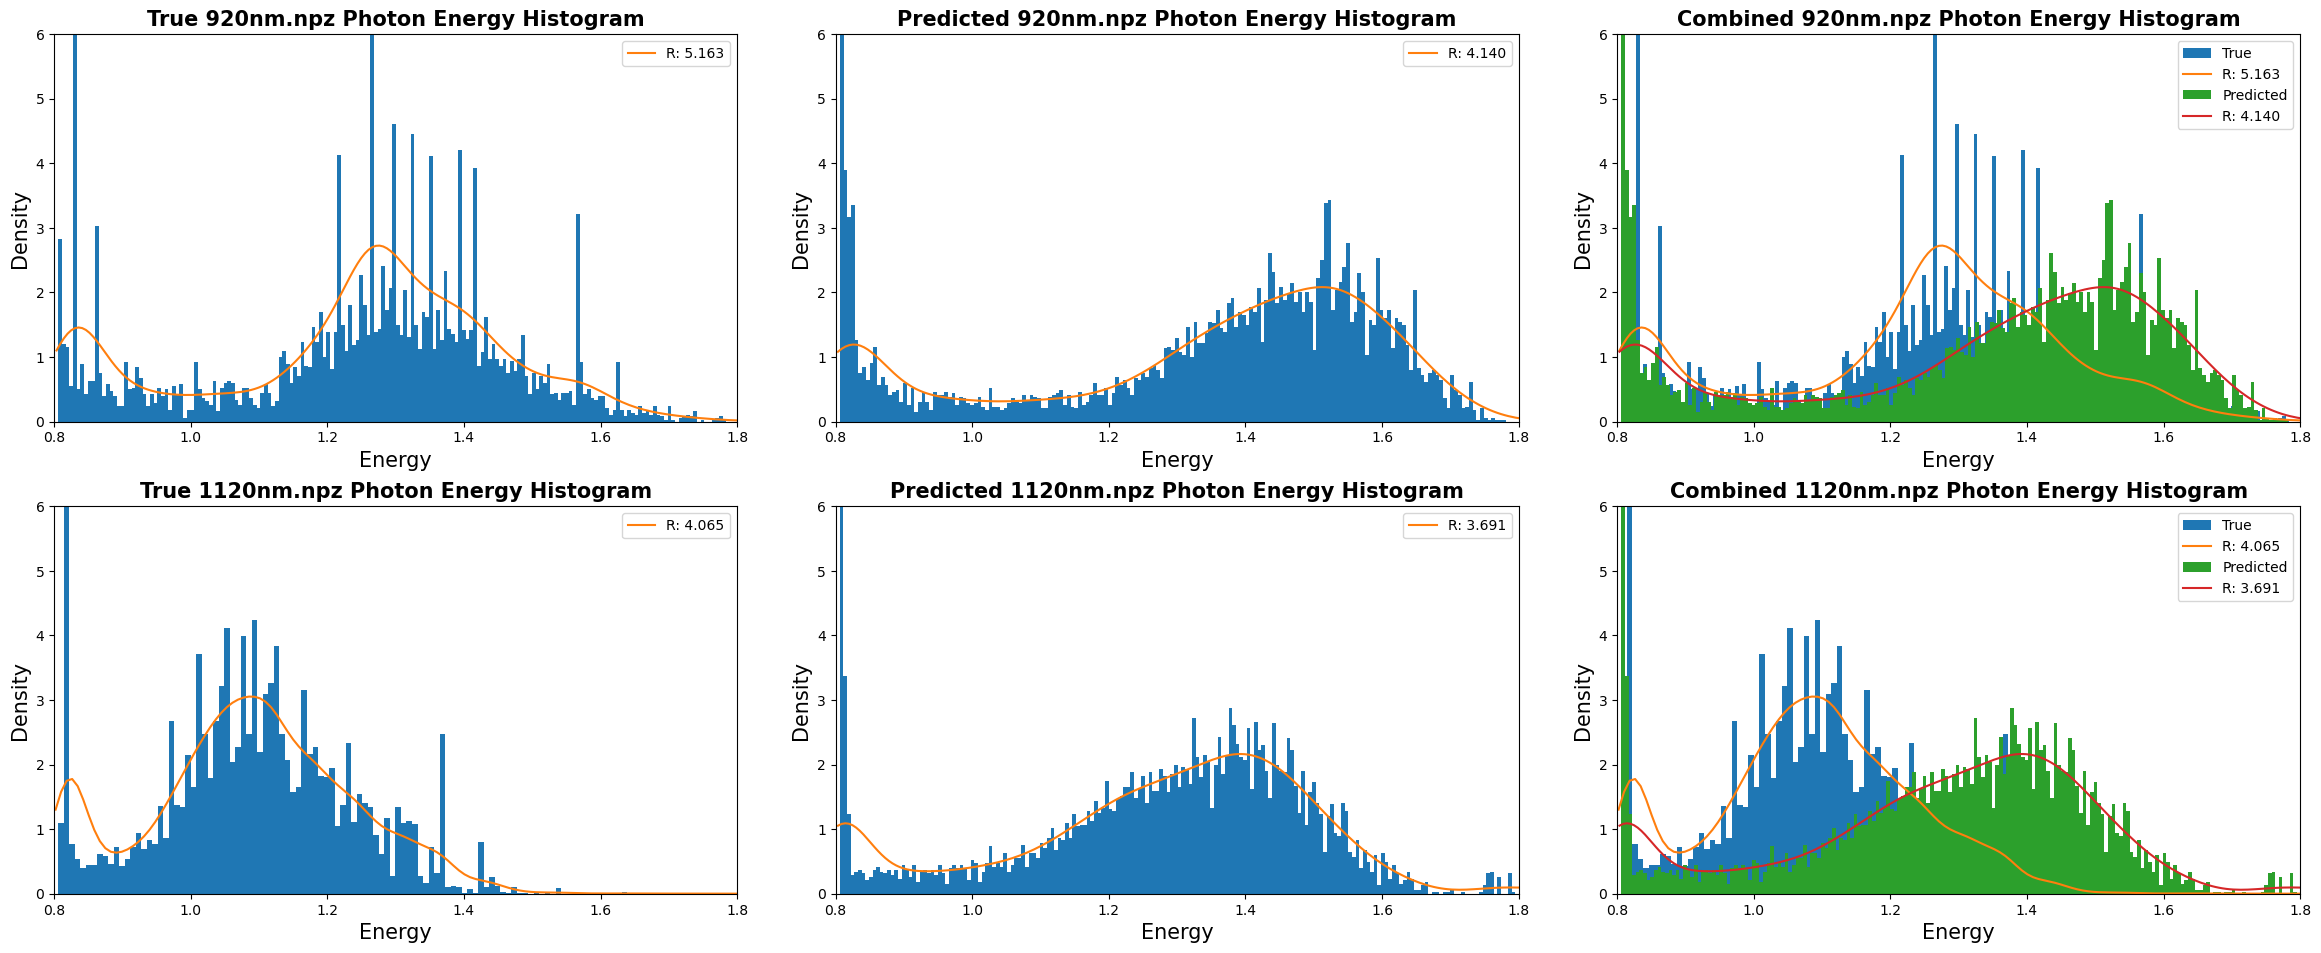

In [ ]:
#Plotting Histograms
fig, ax = plt.subplots(len(eval_dict_storage),3, figsize = (24,5*len(eval_dict_storage)))
fig.tight_layout(pad=4.0)

i = 0
for eval_dict in eval_dict_storage:
    #Plotting True Histogram
    R_true = eval_dict['true_E_Res'][0]
    ax[i,0].hist(eval_dict['true_hist'], bins = n_bins, density = True)
    ax[i,0].plot(eval_dict['plot_true_x'], eval_dict['plot_true_pdf'], label = f'R: {R_true:.3f}')
    ax[i,0].set_ylabel("Density", fontsize = 15)
    ax[i,0].set_xlabel("Energy", fontsize = 15)
    ax[i,0].set_xlim(0.8, 1.8)
    ax[i,0].set_ylim(0,6)
    ax[i,0].set_title("True " + eval_fnames[i] + " Photon Energy Histogram", fontweight = 'bold', fontsize = 15)
    ax[i,0].legend()

    #Plotting Model Predictions Histograms
    R_pred = eval_dict['pred_E_Res'][0]
    ax[i,1].hist(eval_dict['pred_hist'], bins = n_bins, density = True)
    ax[i,1].plot(eval_dict['plot_pred_x'], eval_dict['plot_pred_pdf'], label =  f"R: {R_pred:.3f}")
    ax[i,1].set_ylabel("Density", fontsize = 15)
    ax[i,1].set_xlabel("Energy", fontsize = 15)
    ax[i,1].set_xlim(0.8, 1.8)
    ax[i,1].set_ylim(0,6)
    ax[i,1].set_title("Predicted " + eval_fnames[i] + " Photon Energy Histogram", fontweight = 'bold', fontsize = 15)
    ax[i,1].legend()

    #Overplotting Model Predictions with True Histogram
    ax[i,2].hist(eval_dict['true_hist'], bins = n_bins, density = True, label = "True")
    ax[i,2].plot(eval_dict['plot_true_x'], eval_dict['plot_true_pdf'], label = f'R: {R_true:.3f}')
    ax[i,2].hist(eval_dict['pred_hist'], bins = n_bins, density = True, label = "Predicted")
    ax[i,2].plot(eval_dict['plot_pred_x'], eval_dict['plot_pred_pdf'], label =  f"R: {R_pred:.3f}")
    ax[i,2].set_ylabel("Density", fontsize = 15)
    ax[i,2].set_xlabel("Energy", fontsize = 15)
    ax[i,2].set_xlim(0.8, 1.8)
    ax[i,2].set_ylim(0,6)
    ax[i,2].set_title("Combined " + eval_fnames[i] + " Photon Energy Histogram", fontweight = 'bold', fontsize = 15)
    ax[i,2].legend()

    i += 1

plt.show()

# **Appendix**

Over the course of this project, there came several times when I encountered an error that I thought could not be resolved without significantly rewriting large swathes of the code. In order to preserve things I replaced on the chance they be reprised later, I have stored them here in the appendix. Most of the code here will not work with the code above or does not work outright, so replace things at your own risk.

**Curve Fitting Appendix** <br>
I spent a lot of time writing software to fit gaussians to histograms. Here's a bunch of code, most of it in a dysfunctional state

**Gaussian Mixture Model w/ Likelihood Optimization**

From a glance at the histograms of spectra of different wavelengths, the histogram of the data is best understood as a multi-gaussian cluster. To obtain the parameters for these gaussians, we first use an InterpolatedUnivariateSpline on the bin values from the histogram. Using a gaussian filter (for smoothing) obtains a curve that can be used to fit for parameters.

First, the maximum value of the smoothed-interpolated curve is obtained. When the second derivative of the smoothed-interpolated curve is zero corresponds to the the inflection points. The inflection points on either side of the maximum value of the smoothed-interpolated curve correspond to the same gaussian cluster. Since $1\sigma$ of a gaussian occurs at the inflection points, this can be used to obtain $\mu$ and $\sigma$ for fitting. Then, $1\sigma$ worth of data centered about $\mu$ is removed from the histogram. The process then repeats as many times as there are gaussian clusters in the dataset. $f_i$ is determined by relating the coefficient in front of the gaussian to the maximum value of the data set on each pass, and it's physical significance is to represent the amount of the dataset which is encapsulated in a single cluster. Due to the tails in the histogram data (which are not gaussian) being cut off, $\sum_i f_i < 1$, though the data remains normalized.

$$\begin{align}
G_i &= \frac{f_i}{\sqrt{2 \pi \sigma_i^2}}\exp\left[-\frac{(x-\mu_i)^2}{2 \sigma_i^2}\right]\\
\end{align} $$

Due to the data not being exactly gaussian, after the preliminary fit, a sweep across a grid of smoothing-kernel values and $\mu$ values within $\frac{\sigma}{4}$ is compared to the exact bin values of the initial histogram. The minimum $\chi^2$ is used to determine which combination of $\mu$ and kernel smoothing values will be utilized for the final fit.


In [ ]:
def gaussian(x, f, mu, sigma):
    A = f/np.sqrt(2*np.pi*sigma**2)
    f_gauss = A*np.exp((x-mu)**2/(-2*sigma**2))
    return f_gauss


def spline_int(spectra, n_bins, kernel_size):
    #obtaining the discrete (x, y) pairs directly from the histogram
    density, bins = np.histogram(spectra, bins = n_bins, density = True)

    x = bins[0:-1] + 0.5*(bins[1]-bins[0])
    y = density

    spline = InterpolatedUnivariateSpline(x,y)
    y_spline = spline(x)
    y_smooth = gaussian_filter1d(y_spline, kernel_size)

    return x, y, y_smooth

def best_fit_gaussians(spectra, n_bins, n_clusters):
    #fit a gaussian to data within a standard deviation of the highest point in the spectra
    f_fit = np.empty(n_clusters)
    mu_fit = np.empty(n_clusters)
    sigma_fit = np.empty(n_clusters)
    R_fit = np.empty(n_clusters)

    #define a global spectra to hold onto the non-cluster removed dataset
    global_spectra = spectra

    #Find/fit a gaussian at y_max, remove it, repeat until all clusters have been fit
    kernel_range = np.linspace(2,8, 50) #try different kernel sizes across a range of experimentally viable kernel sizes (verified by eye)
    for i in range(n_clusters):
        kernel_metric = []
        for kernel in kernel_range:
            x, y, y_smooth = spline_int(spectra, n_bins, kernel)
            x_global, _, y_global = spline_int(global_spectra, n_bins, kernel)

            #obtaining guesses for sigma/mu based on y_max of filtered data and the inflection points of y_smooth
            mu_index = np.where(y_smooth == max(y_smooth))[0]
            inflection_index = np.where(np.diff(np.sign(np.gradient(np.gradient(y_smooth)))))[0] #sign changes of the second derivative imply inflection points
            mu = x[mu_index][0]
            inflection_pts = x[inflection_index]
            left_bound = np.where(np.diff(np.sign(inflection_pts - mu*np.ones(len(inflection_pts)))))[0][0] #When (mu - inflection_pt) changes sign, it implies that they correspond to the curve associated with mu
            sigma = np.abs(inflection_pts[left_bound] - inflection_pts[left_bound + 1])/2 #the standard deviation is the difference between the two inflection points divided by two

            #obtaining a guess for the scaling/normalization factor with the
            y_max = y_global[np.where(x_global == mu)][0]
            f = y_max*np.sqrt(2*np.pi*sigma**2)

            #slightly shift the mean value to see if it affects the fit (some of the fits become skewed due to non-uniform distributions)
            mu_range = np.linspace(mu-sigma*0.25, mu+sigma*0.25, 50)
            for mu in mu_range:
                #goodness of kernel metric
                x_kernel = list(filter(lambda x: x <= mu + 2*sigma or x >= mu - 2*sigma, x)) #check two sigma around the mean of the cluster for goodness of fit
                y_kernel = y[np.where(x == x_kernel)]
                chisq = sum((y_kernel - gaussian(x_kernel, f, mu, sigma))**2)
                kernel_metric.append(chisq)

                #if the minimum chi squared is the last entry in the list, update the fit parameters
                if min(kernel_metric) == kernel_metric[-1]:
                    f_fit[i] = f
                    mu_fit[i] = mu
                    sigma_fit[i] = sigma

                    #finding the Full Width Half Maximum for Energy Resolution Purposes
                    y_gaussian = gaussian(x_global, f, mu, sigma)
                    HM = max(y_gaussian)/2
                    HM_index = np.where(np.diff(np.sign(y_gaussian - HM)))[0]
                    FWHM = np.abs(x[HM_index[0]] - x[HM_index[1]])
                    R = mu/FWHM

                    R_fit[i] = R

        #retrieve the leftover data for subsequent fits (if necessary)
        sigma_factor = 1
        spectra = list(filter(lambda x: x >= mu + sigma_factor*sigma or x <= mu - sigma_factor*sigma, spectra))

    if sum(f_fit) > 1:
        print("Warning: normalized to greater than one")

    return f_fit, mu_fit, sigma_fit, R_fit

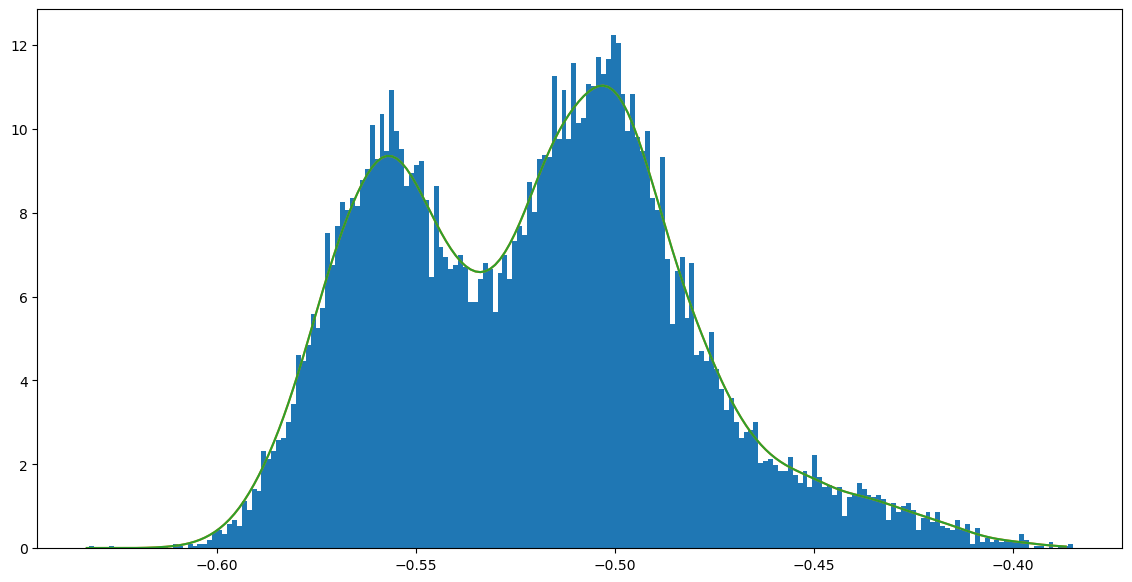

In [ ]:
def quadratic_spline_roots(spline):
    """Returns the roots of a scipy spline."""
    roots = []
    knots = spline.get_knots()
    for a, b in zip(knots[:-1], knots[1:]):
        u, v, w = spline(a), spline((a + b) / 2), spline(b)
        t = np.roots([u + w - 2 * v, w - u, 2 * v])
        t = t[np.isreal(t) & (np.abs(t) <= 1)]
        roots.extend(t * (b - a) / 2 + (b + a) / 2)
    return np.array(roots)

#reloading the masked data so that it's separated by wavelength instead of being tossed all into the same array
sep_spectra = []
for i in range(5):
    data = np.load(datadir+fnames[i])
    mask = data['mask'] #this mask consists of true/false values and removes 'bad' photons (eg: multiple photons incident in a single trace)
    peak_wavelength = data['peak_heights']
    sep_spectra.append(peak_wavelength[mask])

spectra = deque()
spectra.extend(sep_spectra[0])
spectra.extend(sep_spectra[3])

#obtaining the discrete (x, y) pairs directly from the histogram
n_bins = 200
density, bins = np.histogram(spectra, bins = n_bins, density = True)
x = bins[0:-1] - 0.5*(bins[1]-bins[0])


kernel = gaussian_kde(spectra)
pdf_data = kernel(x)
pdf = InterpolatedUnivariateSpline(x, pdf_data, k=3, ext=1)

# compute the maximum of the distribution
pdf_max = 0
peak_location = 0
for root in quadratic_spline_roots(pdf.derivative()):
    if pdf(root) > pdf_max:
        pdf_max = pdf(root)
        peak_location = root.item()
    peak = (peak_location if pdf_max != 0 and peak_location != 0 else np.nan)

    # compute the FWHM
    # noinspection PyArgumentList
    pdf_approx_shifted = InterpolatedUnivariateSpline(x, pdf_data - pdf_max / 2, k=3, ext=1)
    roots = pdf_approx_shifted.roots()
    if roots.size >= 2 and pdf_max != 0 and peak_location != 0:
        indices = np.argsort(np.abs(roots - peak_location))
        roots = roots[indices[:2]]
        fwhm = roots.max() - roots.min()
    else:
        fwhm = np.nan


plt.figure(figsize = (14,7))
plt.hist(spectra, bins = n_bins, density = True)
plt.plot(x, pdf_data)
plt.plot(x,pdf(x))
plt.show()



**Curve_fit**

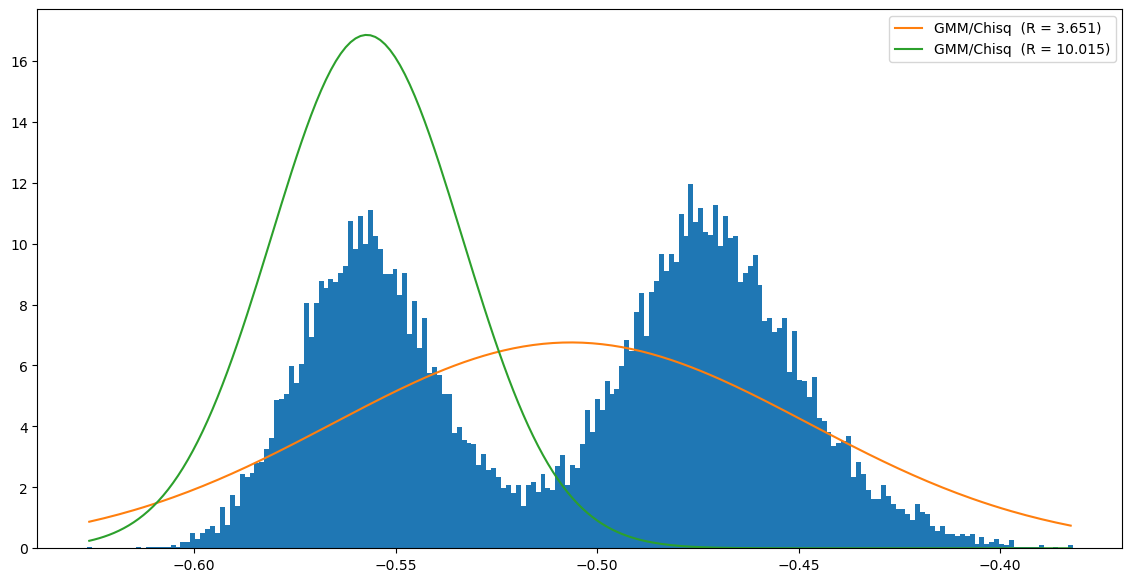

In [ ]:
def gaussian(x, mu, sigma):
    A = 1/np.sqrt(2*np.pi*sigma**2)
    f_gauss = A*np.exp((x-mu)**2/(-2*sigma**2))
    return f_gauss

def gaussian_fit(spectra, n_bins, n_wavelengths, x, y):
    #curve_fitting
    params, pcov = curve_fit(gaussian, x, y)
    return params

def n_wavelength_gaussian_fit(spectra, n_bins, n_wavelengths):
    params = deque()
    for i in range(n_wavelengths):
        #obtaining the discrete (x, y) pairs directly from the histogram
        density, bins = np.histogram(spectra, bins = n_bins, density = True)
        x = bins[0:-1] - 0.5*(bins[1]-bins[0])
        y = density

        #obtaining guesses for sigma/mu for filtering the data to retrieve a histogram
        mu = x[np.where(y == max(y))][0]
        sigma = np.std(spectra)/n_wavelengths

        #fit a gaussian to data within a standard deviation of the highest point in the spectra
        fit_spectra = list(filter(lambda x: x <= mu + sigma or x >= mu - sigma, spectra))
        params.append(gaussian_fit(fit_spectra, n_bins, n_wavelengths, x, y))

        #retrieve the leftover data for subsequent fits (if necessary)
        spectra = list(filter(lambda x: x >= mu + sigma or x <= mu - sigma, spectra))

    return params

n_wavelengths = 2

new_spectra = deque()
new_spectra.extend(sep_spectra[0])
new_spectra.extend(sep_spectra[4])


params = n_wavelength_gaussian_fit(new_spectra, n_bins, n_wavelengths)


plt.figure(figsize = (14,7))
density, bins, _ = plt.hist(new_spectra, bins = n_bins, density = True)
x = bins[0:-1] + 0.5*(bins[1]-bins[0])
for i in range(n_wavelengths):
    mu = params[i][0]
    sigma = params[i][1]
    R = mu/(sigma*2.35)
    plt.plot(x, gaussian(x,mu,sigma), label = f"GMM/Chisq  (R = {R:.3f})")
plt.legend()
plt.show()












deque([[-0.4730289691811013, 0.01958006718429925], [-0.5574680089133919, 0.01652068168675247]])


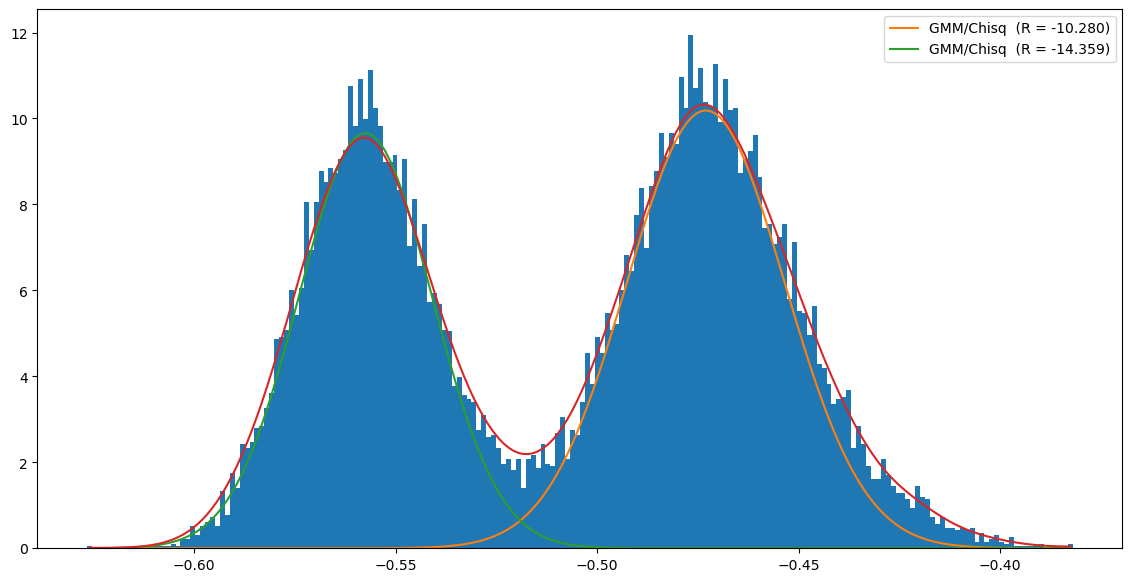

In [ ]:
def spline_int(spectra, n_bins):
    #obtaining the discrete (x, y) pairs directly from the histogram
    density, bins = np.histogram(spectra, bins = n_bins, density = True)

    x = bins[0:-1] + 0.5*(bins[1]-bins[0])
    y = density

    spline = InterpolatedUnivariateSpline(x,y)
    y_spline = spline(x)
    y_smooth = gaussian_filter1d(y_spline, 5)

    return x, y, y_smooth


#Define function to minimize the chisquared later
def likelihood(params, spectra, n_bins):
    #generating the "truth"
    x, _, y_smooth = spline_int(spectra, n_bins)

    #unpacking params for the model
    mu_proper, sigma_proper = params
    mu_proper = np.ones(len(x))*mu_proper
    sigma_proper = np.ones(len(x))*sigma_proper

    #generating the model
    A_proper = 1/(np.sqrt(2*np.pi*sigma_proper**2))
    g_proper = A_proper*np.exp(-(x-mu_proper)**2/(2*sigma_proper**2))
    model = g_proper

    #generating the chisquared likelihood
    chisq = np.sum((y_smooth-model)**2)

    return chisq


def best_fit_gaussians(spectra, n_bins, n_wavelengths):
  params = deque()
  for i in range(n_wavelengths):
      x, y, y_smooth = spline_int(spectra, n_bins)

      #obtaining guesses for sigma/mu for filtering the data to retrieve a histogram
      mu = x[np.where(y_smooth == max(y_smooth))][0]
      inflection_pts = x[np.where(np.diff(np.sign(np.gradient(np.gradient(y_smooth)))))[0]]
      left_bound = np.where(np.diff(np.sign(inflection_pts - mu*np.ones(len(inflection_pts)))))[0][0] #When (mu - inflection_pt) changes sign, it implies that they correspond to the curve associated with mu
      sigma = np.abs(inflection_pts[left_bound] - inflection_pts[left_bound + 1])/2 #the standard deviation is the difference between the two inflection points divided by two

      params.append([mu, sigma])
      #fit a gaussian to data within a standard deviation of the highest point in the spectra
      sigma_factor = 1
      #fit_spectra = list(filter(lambda x: x <= mu + sigma_factor*sigma or x >= mu - sigma_factor*sigma, spectra))
      #params.append(minimize(likelihood, x0 = [mu, sigma], args=(spectra, n_bins), method='Powell').x )

      #retrieve the leftover data for subsequent fits (if necessary)
      spectra = list(filter(lambda x: x >= mu + sigma_factor*sigma or x <= mu - sigma_factor*sigma, spectra))

  return params



n_wavelengths = 2

new_spectra = deque()
new_spectra.extend(sep_spectra[0])
#new_spectra.extend(sep_spectra[2])
new_spectra.extend(sep_spectra[4])

x, y , y_smooth = spline_int(new_spectra, n_bins)

params = best_fit_gaussians(new_spectra, n_bins, n_wavelengths)
print(params)


plt.figure(figsize = (14,7))
density, bins, _ = plt.hist(new_spectra, bins = n_bins, density = True)
prefact = [0.5,0.4]
for i in range(n_wavelengths):
    mu = params[i][0]
    sigma = params[i][1]
    R = mu/(sigma*2.35)
    plt.plot(x, prefact[i]*gaussian(x,mu,sigma), label = f"GMM/Chisq  (R = {R:.3f})")
plt.plot(x,y_smooth)
plt.legend()
plt.show()


In [ ]:
inflection_pts = [0,10,22,28,40,50,60]
mu = 25.8
left_index = np.where(np.diff(np.sign(inflection_pts - mu*np.ones(len(inflection_pts)))))[0][0] #When (mu - inflection_pt) changes sign, it implies that they correspond to the curve associated with mu
sigma = int(np.abs(inflection_pts[left_index] - inflection_pts[left_index + 1])/2) #the standard deviation is the difference between the two inflection points divided by two
print(sigma)

3


**Gaussian Mixture Model w/ Likelihood Optimization**

From a glance at the histograms of spectra of different wavelengths, it seems possible to model the histogram as a multi-gaussian cluster. To obtain the parameters for these gaussians, we can maximize the sum of the likelihoods that a datapoint belongs to a particular gaussian.

$$\begin{align}
\mathscr{L} &= \sum_i\sum_j \frac{f_i}{\sqrt{2 \pi \sigma_i^2}}\exp\left[-\frac{(x_j-\mu_i)^2}{2 \sigma_i^2}\right]\\
\end{align} $$

This likelihood sum is over $j$ data points for $i$ gaussian clusters. Furthermore, the normalization condition dictates that

$$\sum_i f_i = 1 $$


C:\Users\dylan\anaconda3\envs\MKID\lib\site-packages\scipy\optimize\_optimize.py:2790: RuntimeWarning: overflow encountered in double_scalars
  elif (w - wlim)*(wlim - xc) >= 0.0:
C:\Users\dylan\anaconda3\envs\MKID\lib\site-packages\scipy\optimize\_optimize.py:2769: RuntimeWarning: overflow encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\dylan\anaconda3\envs\MKID\lib\site-packages\scipy\optimize\_optimize.py:2763: RuntimeWarning: overflow encountered in double_scalars
  tmp2 = (xb - xc) * (fb - fa)
C:\Users\dylan\anaconda3\envs\MKID\lib\site-packages\scipy\optimize\_optimize.py:2769: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\dylan\anaconda3\envs\MKID\lib\site-packages\scipy\optimize\_optimize.py:2762: RuntimeWarning: overflow encountered in double_scalars
  tmp1 = (xb - xa) * (fb - fc)
C:\Users\dylan\anaconda3\envs\MKID\lib\site-packages\scipy\optimize\_op

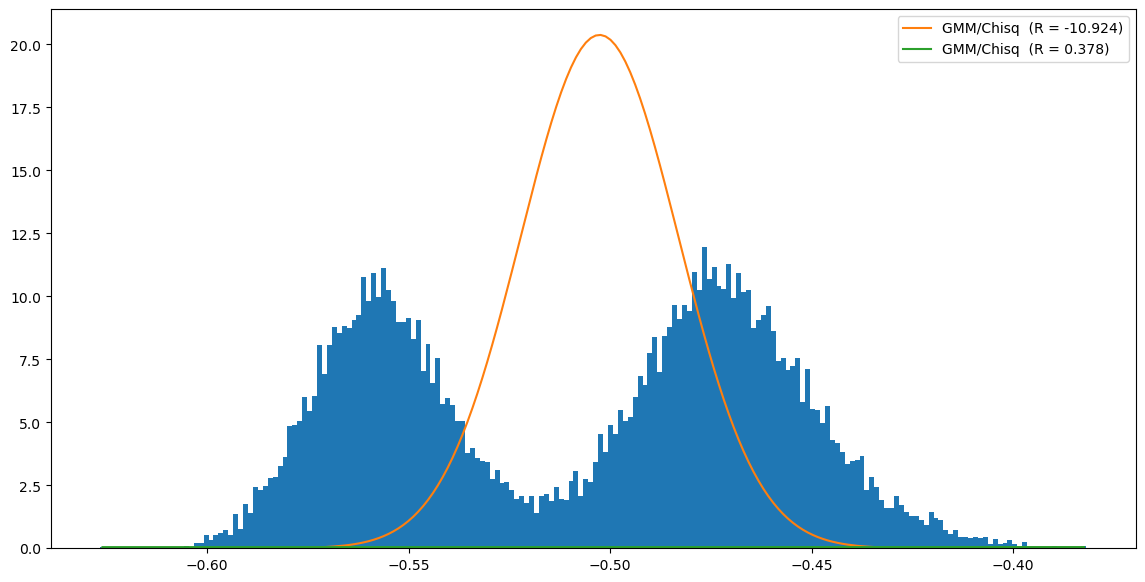

In [ ]:
def spline_int(spectra, n_bins):
    #obtaining the discrete (x, y) pairs directly from the histogram
    density, bins = np.histogram(spectra, bins = n_bins, density = True)

    x = bins[0:-1] + 0.5*(bins[1]-bins[0])
    y = density

    spline = InterpolatedUnivariateSpline(x,y)
    y_spline = spline(x)
    y_smooth = gaussian_filter1d(y_spline, 5)

    return x, y, y_smooth

def likelihood(params, spectra, n_clusters):
    #unpacking params
    f = deque()
    mu = deque()
    sigma = deque()
    f.extend(params[0:n_clusters])
    mu.extend(params[n_clusters:n_clusters*2])
    sigma.extend(params[2*n_clusters:3*n_clusters])

    #Creating an array of ones for parameter multiplication and casting of correct length with each datapoint in spectra
    j_len = len(spectra)

    #calculating likelihood
    likelihood = 0
    for i in range(n_clusters):
        f_i = np.ones(j_len)*f[i]
        mu_i = np.ones(j_len)*mu[i]
        sigma_i = np.ones(j_len)*sigma[i]
        likelihood += f_i/np.sqrt(2*np.pi*sigma_i**2)*np.exp(-(spectra - mu_i)**2/(2*sigma_i**2))

    log_like = sum(np.log(likelihood))

    return log_like*-1 #we want to maximize likelihood using scipy.optimize.minimize

def best_fit_gaussians(spectra, n_bins, n_clusters):
  f_guess = []
  mu_guess = []
  sigma_guess = []
  for i in range(n_clusters):
      x, y, y_smooth = spline_int(spectra, n_bins)

      #obtaining guesses for sigma/mu for filtering the data to retrieve a histogram
      mu = x[np.where(y_smooth == max(y_smooth))][0]
      inflection_pts = x[np.where(np.diff(np.sign(np.gradient(np.gradient(y_smooth)))))[0]]
      left_bound = np.where(np.diff(np.sign(inflection_pts - mu*np.ones(len(inflection_pts)))))[0][0] #When (mu - inflection_pt) changes sign, it implies that they correspond to the curve associated with mu
      sigma = np.abs(inflection_pts[left_bound] - inflection_pts[left_bound + 1])/2 #the standard deviation is the difference between the two inflection points divided by two

      #appending guesses to their respective lists
      f_guess.append(1/n_wavelengths)
      mu_guess.append(mu)
      sigma_guess.append(sigma)

      #retrieve the leftover data for subsequent fits (if necessary)
      sigma_factor = 1
      spectra = list(filter(lambda x: x >= mu + sigma_factor*sigma or x <= mu - sigma_factor*sigma, spectra))


  #Using above method to generate initial guesses
  x0 = deque()
  x0.extend(f_guess)
  x0.extend(mu_guess)
  x0.extend(sigma_guess)
  x0 = list(x0)

  params = minimize(likelihood, x0 = x0, args=(spectra, n_clusters), method='Powell').x

  return params


n_clusters = 2

new_spectra = deque()
new_spectra.extend(sep_spectra[0])
#new_spectra.extend(sep_spectra[2])
new_spectra.extend(sep_spectra[4])

x, y , y_smooth = spline_int(new_spectra, n_bins)

params = best_fit_gaussians(new_spectra, n_bins, n_wavelengths)

plt.figure(figsize = (14,7))
density, bins, _ = plt.hist(new_spectra, bins = n_bins, density = True)

for i in range(n_clusters):
    f = params[i]
    mu = params[i+n_clusters]
    sigma = params[i+2*n_clusters]
    R = mu/(sigma*2.35)
    plt.plot(x, gaussian(x,mu,sigma), label = f"GMM/Chisq  (R = {R:.3f})")

plt.legend()
plt.show()


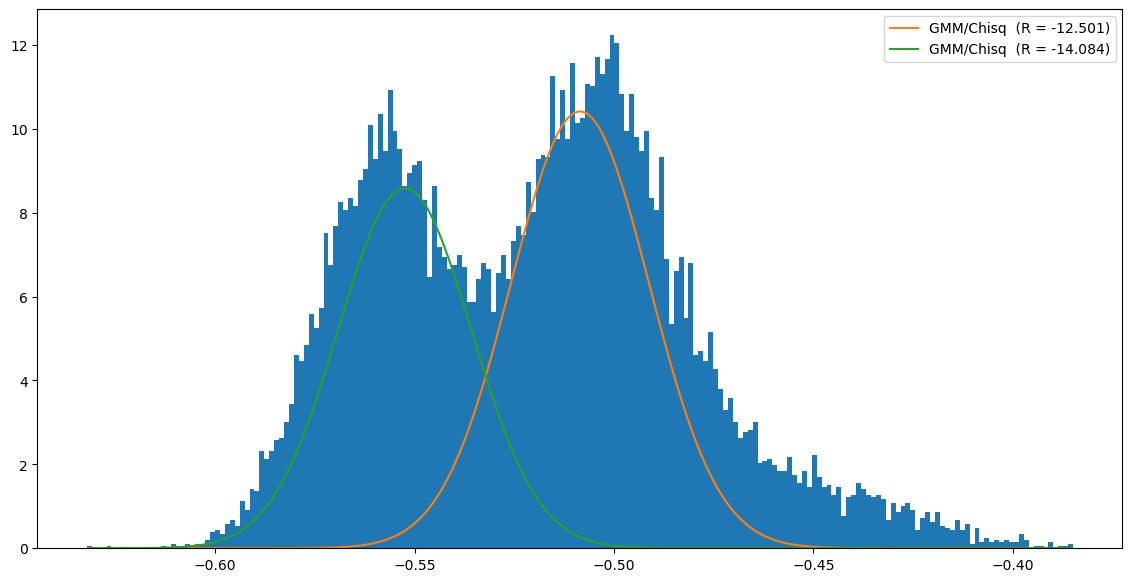

In [ ]:
def gaussian(x, f, mu, sigma):
    A = f/np.sqrt(2*np.pi*sigma**2)
    f_gauss = A*np.exp((x-mu)**2/(-2*sigma**2))
    return f_gauss


def spline_int(spectra, n_bins, kernel_size):
    #obtaining the discrete (x, y) pairs directly from the histogram
    density, bins = np.histogram(spectra, bins = n_bins, density = True)

    x = bins[0:-1] + 0.5*(bins[1]-bins[0])
    y = density

    spline = InterpolatedUnivariateSpline(x,y)
    y_spline = spline(x)
    y_smooth = gaussian_filter1d(y_spline, kernel_size)

    return x, y, y_smooth

def best_fit_gaussians(spectra, n_bins, n_clusters):
    #fit a gaussian to data within a standard deviation of the highest point in the spectra
    f_fit = np.empty(n_clusters)
    mu_fit = np.empty(n_clusters)
    sigma_fit = np.empty(n_clusters)
    R_fit = np.empty(n_clusters)

    #define a global spectra to hold onto the non-cluster removed dataset
    global_spectra = spectra

    #Find/fit a gaussian at y_max, remove it, repeat until all clusters have been fit
    kernel_range = np.linspace(2,8, 100) #try 100 different kernel sizes across a range of experimentally viable kernel sizes (verified by eye)
    for i in range(n_clusters):
        kernel_metric = []
        for kernel in kernel_range:
            x, y, y_smooth = spline_int(spectra, n_bins, kernel)
            x_global, _, y_global = spline_int(global_spectra, n_bins, kernel)

            #obtaining guesses for sigma/mu based on y_max of filtered data and the inflection points of y_smooth
            mu_index = np.where(y_smooth == max(y_smooth))[0]
            inflection_index = np.where(np.diff(np.sign(np.gradient(np.gradient(y_smooth)))))[0] #sign changes of the second derivative imply inflection points
            mu = x[mu_index][0]
            inflection_pts = x[inflection_index]
            left_bound = np.where(np.diff(np.sign(inflection_pts - mu*np.ones(len(inflection_pts)))))[0][0] #When (mu - inflection_pt) changes sign, it implies that they correspond to the curve associated with mu
            sigma = np.abs(inflection_pts[left_bound] - inflection_pts[left_bound + 1])/2 #the standard deviation is the difference between the two inflection points divided by two

            #obtaining a guess for the scaling/normalization factor with the
            y_max = y_global[np.where(x_global == mu)][0]
            f = y_max*np.sqrt(2*np.pi*sigma**2)

            #slightly shift the mean value to see if it affects the fit (some of the fits become skewed due to non-uniform distributions)
            mu_range = np.linspace(mu-sigma*0.25, mu+sigma*0.25, 100)
            for mu in mu_range:
                #goodness of kernel metric
                x_kernel = list(filter(lambda x: x <= mu + 2*sigma or x >= mu - 2*sigma, x)) #check two sigma around the mean of the cluster for goodness of fit
                y_kernel = y[np.where(x == x_kernel)]
                chisq = sum((y_kernel - gaussian(x_kernel, f, mu, sigma))**2)
                kernel_metric.append(chisq)

                #if the minimum chi squared is the last entry in the list, update the fit parameters
                if min(kernel_metric) == kernel_metric[-1]:
                    f_fit[i] = f
                    mu_fit[i] = mu
                    sigma_fit[i] = sigma

                    R = mu/(sigma*2.35)
                    R_fit[i] = R

        #retrieve the leftover data for subsequent fits (if necessary)
        sigma_factor = 1
        spectra = list(filter(lambda x: x >= mu + sigma_factor*sigma or x <= mu - sigma_factor*sigma, spectra))

    if sum(f_fit) > 1:
        print("Warning: normalized to greater than one")

    return f_fit, mu_fit, sigma_fit, R_fit



n_wavelengths = 2

new_spectra = deque()
new_spectra.extend(sep_spectra[0])
new_spectra.extend(sep_spectra[3])
#new_spectra.extend(sep_spectra[4])

x, y , y_smooth = spline_int(new_spectra, n_bins, kernel_size = 5)

f, mu, sigma, R = best_fit_gaussians(new_spectra, n_bins, n_wavelengths)




plt.figure(figsize = (14,7))
density, bins, _ = plt.hist(new_spectra, bins = n_bins, density = True)
for i in range(n_wavelengths):
    R = mu[i]/(sigma[i]*2.35)
    plt.plot(x, gaussian(x,f[i], mu[i],sigma[i]), label = f"GMM/Chisq  (R = {R:.3f})")
plt.legend()
plt.show()


**Deprecated Windowing**<br>
It turns out there's an skimage module which performs the function of creating rolling windows, so I switched over to using it. Here is the (fully functional + debugged) code from my implementation.

In [ ]:
def make_windows(input_array, num_prev_time_steps, num_future_time_steps):
    #identifying the span of each window in terms of given parameters
    span = num_prev_time_steps + 1 + num_future_time_steps #the +1 is for the present time step for which the window is centered around

    #if input_array is 1D
    if len(input_array.shape) == 1:
        #getting parameters from the shape of the input array
        length = len(input_array)
        num_windows = length - (span - 1) #the -1 is to account for the present time step for which the window is centered around

        #initializing windows with correct shape
        windows = np.zeros(shape = (span, num_windows))

        #filling windows with values from the array
        for i in range(num_windows):
            windows[:,i] = input_array[i:span+i]

    #otherwise (which really just means 2D because this isn't able to compensate for 3D or higher input_arrays)
    else:
        #getting parameters from the shape of the input array
        length, height = input_array.shape
        num_windows = length - (span - 1) #the -1 is to account for the present time step for which the window is centered around

        #initializing windows with correct shape
        windows = np.zeros(shape = (span, height, num_windows))

        #filling windows with values from the array
        for i in range(num_windows):
            windows[:,:,i] = input_array[i:span+i]

    #Dataset_from_tensor_slices consumes the first dimension, so we should transpose the windows so the first axis is the axis of windows
    windows = np.transpose(windows)

    return windows


**Deprecated Bootstrapping** <br>
In an attempt to deal with a temporal shift induced by predictions with the most recent model architecture, I rewrote the bootstrapping to scan a symmetric window on either side of the photon incidence, take the maximum value, and rescale based on this. Below is the old method of bootstrapping, which only rescaled based on the point at the photon incidence.

In [ ]:
#Defining the function to minimize to obtain the scaling factor for each generated evaluation dataset
def scaling_factor(rescaling_factor, model_prediction, label_eval):
    #We want to determine the appropriate scaling factor by minimizing the least squares difference of the model and label peaks
    peak_indices = np.where(label_eval != 0)
    label_peaks = label_eval[peak_indices]
    model_peaks = model_prediction[peak_indices]

    #calculate lstsq value(to be minimized)
    lstsq =  np.sum(model_peaks*rescaling_factor - label_peaks)**2

    return lstsq

def find_best_rescaling_factor(model_prediction, label_eval):
    guess = np.random.rand() #Since we only have one parameter, our initial guess shouldn't matter
    rescaling_factor = minimize(scaling_factor, guess, args=(model_prediction, label_eval), method = "Powell").x
    return rescaling_factor

eval_TrainingTime = 0.01 #even if training the model on more than 0.01 second of training time, evaluate it on 0.01 second of traing time because it's faster
N_time_datapoints = int(SampRate*eval_TrainingTime)
time_eval = np.linspace(0,TrainingTime,N_time_datapoints)

#Performing bootstrap resampling: When generating synthetic data with a training time of 0.01 seconds, model_predictions took about 10 seconds per iteration(expect this cell to be computationally expensive)
num_iter = 50
bstrap_list = []
for i in range(num_iter):
    bstrap_model_prediction, bstrap_label = model_predictions(model, i_trace,q_trace, filtered_data, peak_indices, SampRate, eval_TrainingTime, PhotonRate, n_pts, pulse_halfwidth, return_labels = True)
    rescaling_factor_i = find_best_rescaling_factor(bstrap_model_prediction, bstrap_label[1])
    bstrap_list.append(rescaling_factor_i)

bstrap_rescaling_factor = np.mean(bstrap_list)
sigma_rescaling_factor = np.std(bstrap_list)

print(f"Using bootstrap resampling with {num_iter} iterations generates a rescaling factor of {bstrap_rescaling_factor:.3f} ± {sigma_rescaling_factor:.3f}")

**Deprecated Custom Training Routine** <br>
Moving my custom training routine to the archive on the chance it needs to be reprised for future cross-validation of opaque model.fit() results or to replace model.fit() entirely.

In [ ]:
model = create_model()
model.summary()

epochs = 4
for epoch in range(epochs):

    print(f"Epoch: {epoch+1}")


    training_loss = []
    validation_loss = []

    #training step
    for batch in dataset_train:
        loss = model.train_step(batch)
        training_loss.append(loss.get("I II II L"))

    #validation step
    for batch in dataset_val:
        val_loss = model.test_step(batch)
        validation_loss.append(val_loss.get("loss"))

    training_loss = np.asarray(training_loss)
    avg_train = np.mean(training_loss)
    sum_train = sum(training_loss)

    validation_loss = np.asarray(validation_loss)
    sum_val = sum(validation_loss)
    avg_val = np.mean(validation_loss)

    print(f"Average Training Loss: {avg_train}  Summed Training Loss: {sum_train}")
    print(f"Average Validation Loss: {avg_val}  Summed Validation Loss: {sum_val}")

    print("")


Model: "photon__prediction_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_14 (Sequential)  (None, 1)                 232897    
                                                                 
 sequential_15 (Sequential)  (None, 1)                 232897    
                                                                 
Total params: 465,794
Trainable params: 465,794
Non-trainable params: 0
_________________________________________________________________
Epoch: 1
Average Training Loss: 342654.75  Summed Training Loss: 1027621634.625
Average Validation Loss: 21.582780838012695  Summed Validation Loss: 64726.76412999723

Epoch: 2
Average Training Loss: 164560.40625  Summed Training Loss: 493516658.546875
Average Validation Loss: 21.71315574645996  Summed Validation Loss: 65117.75528717041

Epoch: 3
Average Training Loss: 109354.453125  Summed Training Loss: 327954011.3046875
Average V

**Deprecated Model API**

In [ ]:
#input_shape = (sequence_length, vector_size)
#input_dataset = tf.keras.Input(shape = input_shape, dtype = None, tensor = dataset_train) #Timeseries dataset consisting of IQ data with photon energy for each window index
#input_dataset, targets = input_dataset.get_single_element()

#defining the TensorSpec for each element of the BatchDataset tuple (var name in implementation is dataset_train) for the type_spec of the input layer
#input_spec = tf.TensorSpec(shape=[None, None,3], dtype=tf.float32)
#target_spec = tf.TensorSpec(shape=(None,), dtype=tf.float32, name=None)
#Batch_spec = tf.data.DatasetSpec(element_spec = (input_spec, target_spec), dataset_shape = tf.TensorShape([]))
#Batch_spec = tf.data.DatasetSpec.from_value(dataset_train)

class splitter(tf.keras.layers.Layer):
    def __init__(self):
        super(splitter, self).__init__()

    @tf.function
    def call(self, input_dataset, probability_output, energy_output):
        data, targets = input_dataset
        loss_value = global_loss(probability_output, energy_output, targets, data)
        return loss_value


#Input Layer(s)
data, targets = tf.keras.Input(type_spec = (tf.data.DatasetSpec.from_value(dataset_train).element_spec[0],tf.data.DatasetSpec.from_value(dataset_train).element_spec[1]))
#data, targets = input_dataset.unbatch()

#convolution node with multiple inputs
input_dataset_convolve = tf.keras.layers.Conv1D(filters = 64, kernel_size = 5, strides = 1, padding = 'causal',activation = 'relu', input_shape = input_shape)(input_dataset)

#Bidirectional LSTM node with multiple inputs
input_dataset_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True))(input_dataset_convolve)
input_dataset_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True))(input_dataset_lstm)

#output layers
probability_output = tf.keras.layers.Dense(1, activation = 'sigmoid')(input_dataset_lstm)
energy_output = tf.keras.layers.Dense(1)(input_dataset_lstm)

#instantiate an end-to-end model that predicts at each timestep the probability and energy
model = tf.keras.Model(
    inputs = input_dataset,
    outputs = [probability_output, energy_output]
)

#Defining loss as a tensor within the model so that it can act on multiple outputs
loss = global_loss(probability_output, energy_output, targets, input_data)
model.add_loss(loss)


'''
@tf.function
def compute_loss(input_dataset):
    data, targets = splitter(input_dataset)
    loss = global_loss(probability_output, energy_output, targets, data)
    return

split_dataset = splitter()
loss = split_dataset(input_dataset, probability_output, energy_output)
loss = compute_loss(input_dataset)
model.add_loss(loss)
#Defining loss as a tensor within the model so that it can act on multiple outputs
'''

#hyperparameter
epochs = 500

#compile model
model.compile(
      optimizer='adam'
       )


**Deprecated Custom Loss Functions**

The `peak_loss` function penalizes the model for failing to match the label values when the label value corresponds to a photon peak. It's internal logic relies on the label having a value of zero at indices where photons are not incident. Though this function is only 22 lines long (excluding comments and whitespace), it took me nearly 18 hours of coding to implement it successfully. It says something about me that the most exciting event of my life in recent memory was it running without erroring, but that's a problem for someone with a degree in psychology.

In [ ]:
def peak_loss(y_actual, y_pred):
    '''
    Reshaping Everything to a Rank One Tensor(vector) of length batch_size*sequence_length so I don't have an aneurysm trying to debug this
    '''
    #reshape y_actual and y_pred to have shape[batch_size, sequence_length]
    y_actual = tf.stack([y_actual]*sequence_length, axis = -1) #y_actual has shape [batch_size] and needs to be stacked sequence_length times
    y_pred = tf.squeeze(y_pred) #y_pred has shape[batch_size, sequence_length, 1], squeeze reduces it to a rank-2 tensor

    #now reshape y_actual and y_pred to both be rank 1 tensors of length batch_size*sequence_length
    y_actual = tf.reshape(y_actual, shape = [-1])
    y_pred = tf.reshape(y_pred, shape = [-1])

    #To make sure the scattered tensors are the right shapes, define a shape of length batch_size*sequence_length to be used later
    shape = tf.constant([batch_size*sequence_length])

    '''
    Creating Loss Tensor for indices where photons are incident
    '''
    #Obtaining indices where photons are incident
    peak_indices = tf.where(y_actual != 0) #tf.where always returns tf.int64 tensors, but we want them in tf.int32 to match the rest of our data
    peak_indices = tf.cast(peak_indices, dtype = tf.int32)

    #calculating loss at peak indices and creating a zero-initialized tensor with loss at the peak indices
    peak_loss = tf.math.square(tf.gather(y_actual,peak_indices) - tf.gather(y_pred,peak_indices)) #vstacks tf.gathered values
    peak_loss = tf.squeeze(peak_loss) #reduces peak_loss from a rank 2 tensor to a rank 1 tensor by removing the extra axis
    peak_loss_tensor = tf.scatter(peak_indices, peak_loss, shape)

    '''
    Creating Loss Tensor for indices where photons are NOT incident
    '''
    #Obtaining indices where photons are not incident
    non_peak_indices = tf.where(y_actual == 0) #tf.where always returns tf.int64 tensors, but we want them in tf.int32 to match the rest of our data
    non_peak_indices = tf.cast(non_peak_indices, dtype = tf.int32)

    #calculating loss at those indices
    non_peak_weight = tf.constant(0.01) #We don't really care about minimizing loss when not at a peak so we give this loss a small weight
    non_peak_loss = tf.math.square(tf.gather(y_actual,non_peak_indices) - tf.gather(y_pred,non_peak_indices))
    non_peak_loss = tf.scalar_mul(non_peak_weight, non_peak_loss)
    non_peak_loss = tf.squeeze(non_peak_loss) #reduces peak_loss from a rank 2 tensor to a rank 1 tensor by removing the extra axis
    non_peak_loss_tensor = tf.scatter(non_peak_indices, non_peak_loss, shape)

    '''
    Summing the two sparse loss tensors together to obtain a full loss tensor and acquire the mean loss for each y_actual
    '''
    full_loss_tensor = peak_loss_tensor + non_peak_loss_tensor

    return full_loss_tensor


The `adjacent_loss` function penalizes the model for failing to match the label at peak indices and at a given number of indices that are adjacent to the peak indices. It currently does not run without erroring.

In [ ]:
def adjacent_indices(index):
    #If there is a peak in the index, the index passed here will not be empty
    if tf.shape(index)[0] != 0:

        # reshape for tiling purposes
        index = tf.reshape(index, shape = [-1])

        #depending on the index's location with respect to the window, decide how many adjacent indices to include
        if index == tf.constant(0):
            a = tf.tile(index, [3])
            b = tf.constant([0, 1, 2], shape=[3, 1], dtype=tf.int32)
            sliced = tf.slice((a + b), begin=[0,0], size=[3, 1])

        elif index == tf.constant(1):
            a = tf.tile(index, [4])
            b = tf.constant([-1, 0, 1, 2], shape=[4, 1], dtype=tf.int32)
            sliced = tf.slice((a + b), begin=[0,0], size=[4, 1])

        elif index == tf.constant(batch_size*sequence_length - 2):
            a = tf.tile(index, [4])
            b = tf.constant([-2,-1, 0, 1], shape=[4, 1], dtype=tf.int32)
            sliced = tf.slice((a + b), begin=[0,0], size=[4, 1])

        elif index == tf.constant(batch_size*sequence_length-1):
            a = tf.tile(index, [3])
            b = tf.constant([-2,-1, 0], shape=[3, 1], dtype=tf.int32)
            sliced = tf.slice((a + b), begin=[0,0], size=[3, 1])

        else:
            a = tf.tile(index, [5])
            b = tf.constant([-2, -1, 0, 1, 2], shape=[5, 1], dtype=tf.int32)
            sliced = tf.slice((a + b), begin=[0,0], size=[5, 1])

        return sliced

    #if index is empty, return the index
    else:
        return index



def adjacent_loss(y_actual, y_pred):
    '''
    Reshaping Everything to a Rank One Tensor(vector) of length batch_size*sequence_length so I don't have an aneurysm trying to debug this
    '''
    #reshape y_actual and y_pred to have shape[batch_size, sequence_length]
    y_actual = tf.stack([y_actual]*sequence_length, axis = -1) #y_actual has shape [batch_size] and needs to be stacked sequence_length times
    y_pred = tf.squeeze(y_pred) #y_pred has shape[batch_size, sequence_length, 1], squeeze reduces it to a rank-2 tensor

    #now reshape y_actual and y_pred to both be rank 1 tensors of length batch_size*sequence_length
    y_actual = tf.reshape(y_actual, shape = [-1])
    y_pred = tf.reshape(y_pred, shape = [-1])

    #To make sure the scattered tensors are the right shapes, define a shape of length batch_size*sequence_length to be used later
    shape = tf.constant([batch_size*sequence_length])

    '''
    Creating Loss Tensor for indices where photons are incident
    '''
    #Obtaining indices where photons are incident
    peak_indices = tf.where(y_actual != 0) #tf.where always returns tf.int64 tensors, but we want them in tf.int32 to match the rest of our data
    peak_indices = tf.cast(peak_indices, dtype = tf.int32)
    peak_indices = adjacent_indices(peak_indices)


    #calculating loss at peak indices and creating a zero-initialized tensor with loss at the peak indices
    peak_loss = tf.math.square(tf.gather(y_actual,peak_indices) - tf.gather(y_pred,peak_indices)) #vstacks tf.gathered values
    peak_loss = tf.squeeze(peak_loss) #reduces peak_loss from a rank 2 tensor to a rank 1 tensor by removing the extra axis
    peak_loss_tensor = tf.scatter(peak_indices, peak_loss, shape)

    '''
    Creating Loss Tensor for indices where photons are NOT incident
    '''
    #Obtaining indices where photons are not incident
    non_peak_indices = tf.where(y_actual == 0) #tf.where always returns tf.int64 tensors, but we want them in tf.int32 to match the rest of our data
    non_peak_indices = tf.cast(non_peak_indices, dtype = tf.int32)

    #calculating loss at those indices
    non_peak_weight = tf.constant(0.01) #We don't really care about minimizing loss when not at a peak so we give this loss a small weight
    non_peak_loss = tf.math.square(tf.gather(y_actual,non_peak_indices) - tf.gather(y_pred,non_peak_indices))
    non_peak_loss = tf.scalar_mul(non_peak_weight, non_peak_loss)
    non_peak_loss = tf.squeeze(non_peak_loss) #reduces peak_loss from a rank 2 tensor to a rank 1 tensor by removing the extra axis
    non_peak_loss_tensor = tf.scatter(non_peak_indices, non_peak_loss, shape)

    '''
    Summing the two sparse loss tensors together to obtain a full loss tensor and acquire the mean loss for each y_actual
    '''
    full_loss_tensor = peak_loss_tensor + non_peak_loss_tensor

    return full_loss_tensor


The `naive_loss` function penalizes the model for failing to match the label at any batch containing a peak. This essentially is a crude way to implement the `adjacent_loss` function where the adjacent indices are the entire batch size.

In [ ]:
def naive_loss(y_actual, y_pred):
    print(tf.shape(y_actual), tf.shape(y_pred))

    peaks = tf.where(y_actual != 0)

    if tf.shape(peaks)[0] != 0:
        loss = tf.keras.backend.square(y_actual - y_pred)
    else:
        weight = 0.01
        loss = tf.keras.backend.square(y_actual - y_pred)
        loss = tf.scalar_mul(weight, loss)
    return loss

**Deprecated Data Generation Structure**<br>
This data structure attempts to create windowed/batched datasets by hand rather than with the tensorflow function. Abandoned since model.fit doesn't support multiple dataset inputs; supposedly it should work if one creates a dictionary of datasets but after four hours of pain I decided to rewrite everything, *again*. I've lost count of how many times I've rewritten/restructured everything.

In [ ]:
def normalize(data):
    mean = np.mean(data)
    std = np.std(data)
    return (data-mean)/(std)

def window_dataset(time_series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(time_series) #creates a dataset of tensors at each index of the time_series
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True) #calls the window method
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) #transforms the dataset into tensors elementwise
    batches = dataset.batch(batch_size) #batches the dataset
    return batches

data = np.load('training.npz')
I = data['I']
Q = data['Q']
label = data['label']
time = data['time']

#Only normalize the input data so that the target output isn't warped
I = normalize(I)
Q = normalize(Q)
photon_prob = label[0]
photon_energy = label[1]

#hyperparameters
sequence_length = 50
batch_size = 5
split_fraction = 0.8
length = len(I)
split_index = int(length*split_fraction)


#training data
I_train = window_dataset(I[:split_index], sequence_length, batch_size)
Q_train = window_dataset(Q[:split_index], sequence_length, batch_size)
probability_train = window_dataset(photon_prob[:split_index], sequence_length, batch_size)
energy_train = window_dataset(photon_energy[:split_index], sequence_length, batch_size)
dataset_train = {
    "I_input": I_train,
    "Q_input": Q_train,
    "probability_input": probability_train,
    "energy_input": energy_train
}


#training data
I_val = window_dataset(I[split_index:], sequence_length, batch_size)
Q_val = window_dataset(Q[split_index:], sequence_length, batch_size)
probability_val = window_dataset(photon_prob[split_index:], sequence_length, batch_size)
energy_val = window_dataset(photon_energy[split_index:], sequence_length, batch_size)
dataset_val = {
    "I_input": I_val,
    "Q_input": Q_val,
    "probability_input": probability_val,
    "energy_input": energy_val
}

**Deprecated Data Processing Structure** <br>
To fix a problem with training and validation loss generations having differences on the order of 8 magnitudes, I decided to completely remove the tf.keras.utils.timeseries_dataset_from_array from my Data Processing. I don't know if it'll be effective, which is why this is going to the archive. This removed a lot of opaqueness from the data processing, giving me finer control over precisely what was going on and the ability to actually see/understand what is going on since I wrote it :p

In [ ]:
def normalize(data):
  mean = np.mean(data)
  std = np.std(data)
  return (data-mean)/(std)


data = np.load('training.npz')
I = data['I']
Q = data['Q']
label = data['label']
time = data['time']



#Only normalize the input data so that the target output isn't warped
I = normalize(I)
Q = normalize(Q)


'''
INPUT ARRAYS
'''
#create an array with the time data as it's 0 axis for tf.keras.utils.timeseries_dataset_from_array
input_data = np.zeros(shape=(I.size,3))
input_data[:,0] = time #time data as 0 axis for tf.keras.utils.timeseries_dataset_from_array
input_data[:,1] = I
input_data[:,2] = Q



#set up training dataset
split_fraction = 0.8
sequence_length = 100 #This hyperparameter describes how many timesteps each windowed dataset includes
batch_size = 100 #This hyperparameter describes how many datapoints the model will look at before adjusting model parameters
vector_size = input_data[0,:].size
vector_length = input_data[:,0].size
sampling_rate = 1
split_index = int(split_fraction*vector_length)
input_shape = (sequence_length, vector_size)


'''
The goal is to create a series of sequences which will be ordered so the last element of each sequence is an element of the target
dataset. The preceding elements of that sequence are elements of the input dataset. The series of sequences are chronologically
ordered so that the first sequence contains the first (sequence_length-1) indices of the input data, and then the corresponding
element of the target data. The last sequence would then contain the last target data point and the preceding (sequence_length - 1)
datapoints.

Another way to think about it is like a series of sliding windows which sequentially break the input data into multiple overlapping
sequences of size (sequence_length - 1). The first window of inputs(drawn from input_data) is going to be the first (sequence_length - 1)
indices of input_data. Then, the final index of the first window will be drawn from input_targets. Reframing the input_data and the
input_targets allows the relevant indices to line up such so that input_targets[0] corresponds to input_data[sequence_length-1],
and so on and so forth.

The reason for doing this is to create a timeseries dataset which will be chronologically ordered, complete with batches and targets
so that model.fit uses past timesteps and the current timestep of the input_data to predict the current timestep of the target_data.
'''


#separate the labels
probability_targets = label[0] #we don't actually use this, sadly :(
energy_targets = label[1]

#create correctly framed input data
input_targets = energy_targets[sequence_length:] #reframe the target data to include everything after a sequence length's worth of time steps
input_data = input_data[:-sequence_length] #reframe the input data to include everything up to a sequence length's worth of time steps


'''
TRAINING DATASET
'''

dataset_train = tf.keras.utils.timeseries_dataset_from_array(
      data = input_data,
      targets = input_targets,
      batch_size = batch_size,
      sequence_length = sequence_length,
      sequence_stride = 1,
      end_index = split_index
  )


'''
VALIDATION DATASET
'''
dataset_val = tf.keras.utils.timeseries_dataset_from_array(
      data = input_data,
      targets = input_targets,
      sequence_length = sequence_length,
      batch_size = batch_size,
      sequence_stride = 1,
      start_index = split_index
  )
